In [ ]:
########################################
# 0. 환경 설정 및 라이브러리 설치 (Colab)
########################################
# Google Drive 연동 (Colab 환경인 경우)
from google.colab import drive
drive.mount('/content/gdrive')

# 필요한 라이브러리 설치
!pip install optuna keras-tuner statsmodels prophet tensorflow==2.12.0 tensorflow-addons==0.23.0 xgboost

########################################
# 라이브러리 Import 및 한글 폰트 설정
########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

# Scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler


# Statsmodels & Prophet
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# TensorFlow / Keras & TCN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, clone_model, Model
from tensorflow.keras.layers import (InputLayer, Dense, Dropout, LSTM,
                                     SimpleRNN, GRU, Conv1D, MaxPooling1D, Flatten)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# XGBoost
from xgboost import XGBRegressor

# Optuna
import optuna

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 한글 폰트 설정 (Colab)
!apt-get update -qq
!apt-get install -qq fonts-nanum
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 임포트 및 한글 폰트 설정 완료!")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
라이브러리 임포트 및 한글 폰트 설정 완료!


In [ ]:
########################################
# 2. 데이터 로드 및 전처리
########################################
def load_data(data_path):
    """
    여러 인코딩 방식으로 CSV 파일을 불러옵니다.
    """
    try:
        try:
            df_ = pd.read_csv(data_path, encoding='cp949')
        except UnicodeDecodeError:
            try:
                df_ = pd.read_csv(data_path, encoding='latin-1')
            except UnicodeDecodeError:
                df_ = pd.read_csv(data_path, encoding='cp1252')
        print("[INFO] 데이터 불러오기 성공!")
        return df_
    except FileNotFoundError:
        print(f"[ERROR] 파일을 찾을 수 없습니다. 경로: {data_path}")
    except Exception as e:
        print("[ERROR] 예기치 못한 에러 발생:", e)

DATA_PATH = '/content/gdrive/MyDrive/hwda02/data/Processed_COVID_Data_Filled_Plus_Traffic.csv'
df = load_data(DATA_PATH)

[INFO] 데이터 불러오기 성공!


In [ ]:

# 원본 변수 목록
original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)',' 평균최고기온(℃)','평균일강수량(mm)','최다일강수량(mm)','평균풍속(m/s)','최대풍속(m/s)','최대순간풍속(m/s)','평균습도(%rh)','최저습도(%rh)','일조합(hr)','일사합(MJ/m2)','Traffic']

# Cases 차분 변수 추가
df['Cases_Diff'] = df['Cases'].diff(1)

# Date 컬럼 처리 및 정렬
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values('Date').dropna(subset=['Date']).reset_index(drop=True)

In [ ]:

# 간단 EDA 출력
print("\n데이터 예시(상위 5행):")
print(df.head())
print("\n데이터 info:")
print(df.info())
print("\n데이터 통계치:")
print(df.describe())


데이터 예시(상위 5행):
        Date  Cases       SO2        CO        O3       NO2       PM10  \
0 2020-02-01      0  0.003274  0.699089  0.026038  0.022698  63.185218   
1 2020-02-02      0  0.003502  0.748826  0.028493  0.020737  69.092334   
2 2020-02-03      0  0.003140  0.463362  0.029590  0.015894  32.560316   
3 2020-02-04      3  0.003329  0.465114  0.023674  0.019638  29.410079   
4 2020-02-05      3  0.003002  0.374520  0.029291  0.011450  22.960480   

        PM25  평균기온(℃)  평균최고기온(℃)  ...  최다일강수량(mm)  평균풍속(m/s)  최대풍속(m/s)  \
0  47.416719      2.2        7.8  ...         0.2        1.5       12.5   
1  52.897434      2.1        7.8  ...         0.7        1.3        9.5   
2  21.600817      1.3        5.7  ...         0.7        2.3       13.1   
3  18.842018      0.1        6.3  ...         2.0        1.8       13.4   
4  11.594881     -3.6        1.0  ...        26.0        3.0       14.7   

   최대순간풍속(m/s)  평균습도(%rh)  최저습도(%rh)  일조합(hr)  일사합(MJ/m2)  Traffic  Cases_Diff  
0      

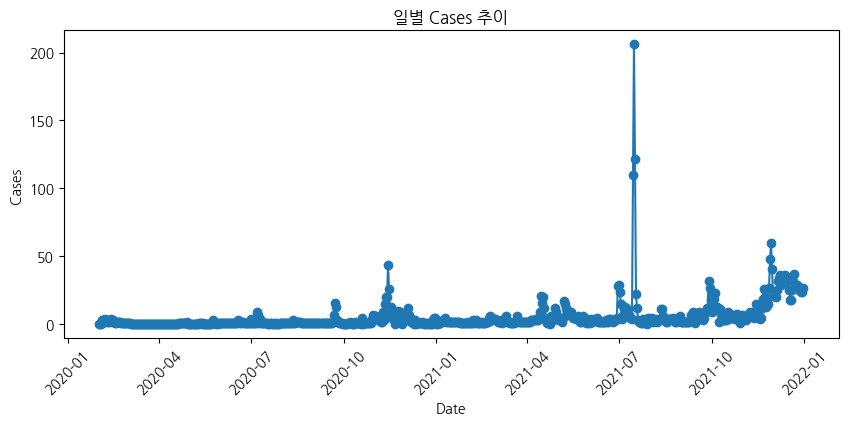

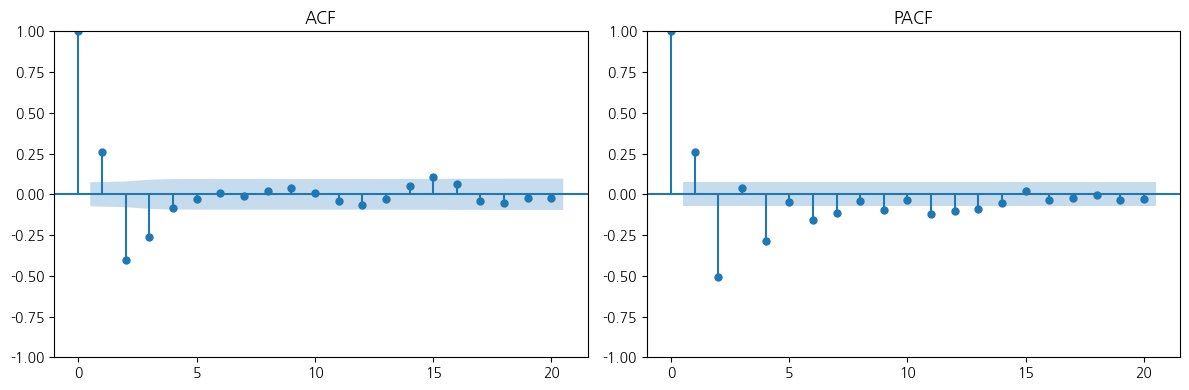

In [ ]:
########################################
# 3. 간단 EDA (시각화)
########################################
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Cases'], marker='o')
plt.title("일별 Cases 추이")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.show()

# ACF 및 PACF 플롯
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(df['Cases_Diff'].dropna(), lags=20, ax=plt.gca())
plt.title("ACF")
plt.subplot(1,2,2)
plot_pacf(df['Cases_Diff'].dropna(), lags=20, ax=plt.gca(), method='ywm')
plt.title("PACF")
plt.tight_layout()
plt.show()

In [ ]:

########################################
# 4. Lag Feature 생성
########################################
def create_lag_features(dataframe, col_targets, lags):
    """
    col_targets에 대해 지정된 lags 만큼의 새로운 컬럼 생성.
    예: lags=(1,7,14) → 'col_target_lag1', 'col_target_lag7', 'col_target_lag14'
    """
    df_ = dataframe.copy()
    for col_target in col_targets:
        for lag in lags:
            df_[f"{col_target}_lag{lag}"] = df_[col_target].shift(lag)
    df_.dropna(inplace=True)
    return df_

df = create_lag_features(df, ['O3', 'PM25', '평균기온(℃)', '평균습도(%rh)','평균풍속(m/s)','Cases'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14])

In [ ]:

########################################
# 6. 시퀀스 데이터 생성 함수
########################################
def make_sequence_data(X_scaled, y_values, window):
    """
    window 길이만큼 슬라이딩 윈도우로 시퀀스 데이터를 생성합니다.
    X_seq: [샘플 수, window, feature 수]
    y_seq: window 이후의 target 값
    """
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - window):
        X_seq.append(X_scaled[i:i+window])
        y_seq.append(y_values[i+window])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
########################################
# 7. 모델 성능 평가 함수
########################################
def evaluate_performance(y_true, y_pred, model_name="Model"):
    mae_value = mean_absolute_error(y_true, y_pred)
    rmse_value = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_value = mean_absolute_percentage_error(y_true, y_pred)
    print(f"[{model_name}] MAE={mae_value:.3f}, RMSE={rmse_value:.3f}, MAPE={mape_value:.3f}")
    return {'model': model_name, 'MAE': mae_value, 'RMSE': rmse_value, 'MAPE': mape_value}

In [ ]:
# feature_cols = ['SO2','CO','O3','NO2','O3_lag10','평균기온(℃)_lag10','최고기온(℃)', '평균풍속(m/s)','Traffic','Cases_lag1']
feature_cols = df.columns.difference(['Date', 'Cases'])

In [ ]:
########################################
# 5. Train/Test 분리 (날짜 기준, SARIMAX)
########################################
#  2021-07-31을 기준으로 분할
########################################
split_date = pd.to_datetime('2021-07-31')
train_df = df[df['Date'] <= split_date].copy()
test_df = df[df['Date'] > split_date].copy()

print(f"Train={train_df.shape}, Test={test_df.shape}")

X_train = train_df[feature_cols]
y_train = train_df['Cases']
X_test  = test_df[feature_cols]
y_test  = test_df['Cases']

# 결측 제거(Shift로 생긴 결측)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(533, 108), Test=(153, 108)
최종 학습세트 크기: (533, 106) 테스트세트 크기: (153, 106)


In [ ]:
########################################
# 데이터 스케일링
########################################
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# y는 스케일링 안함
scaler_y = MinMaxScaler()
y_train_scaled = y_train
y_test_scaled = y_test

In [ ]:
########################################
# SARIMAX
########################################

feature_cols = ['SO2','CO','O3','NO2','O3_lag8','PM25','Traffic','Cases_lag1']

def train_sarimax(train_data, test_data, exog_cols, order=(1,0,1), seasonal_order=(0,0,1,7)):
    """
    SARIMAX(ARIMAX) 모델을 학습하고 예측값을 반환.
    order, seasonal_order는 필요에 따라 조정.
    """
    # train
    y_train_sar = train_data['Cases']
    X_train_sar = train_data[exog_cols]

    # test
    y_test_sar  = test_data['Cases']
    X_test_sar  = test_data[exog_cols]

    model = sm.tsa.statespace.SARIMAX(
        endog=y_train_sar,
        exog=X_train_sar,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    print("SARIMAX 학습 완료! summary:\n", result.summary())

    # 예측
    n_test = len(y_test_sar)
    forecast = result.predict(
        start=len(y_train_sar),
        end=len(y_train_sar)+n_test-1,
        exog=X_test_sar
    )
    return forecast


sarimax_pred = train_sarimax(train_df, test_df, exog_cols=feature_cols)
sarimax_result = evaluate_performance(y_test, sarimax_pred, model_name="SARIMAX")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMAX 학습 완료! summary:
                                      SARIMAX Results                                     
Dep. Variable:                             Cases   No. Observations:                  533
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood               -1750.368
Date:                           Mon, 17 Feb 2025   AIC                           3524.736
Time:                                   00:06:30   BIC                           3575.874
Sample:                                        0   HQIC                          3544.762
                                           - 533                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SO2         1740.5430   1.98e-06   8.78e+08      0.000    1740.543    1740.543
CO           -10.6

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
########################################
# 5. Train/Validation/Test 분리 및 스케일링
########################################
feature_cols = ['SO2','CO','O3','NO2','O3','PM25','최고기온(℃)', '평균풍속(m/s)','Traffic','Cases_lag1']

# 날짜 기준 분할 (Validation < Test)
split_date_test = pd.to_datetime('2021-07-31')
split_date_val = pd.to_datetime('2021-05-31')

train_df = df[df['Date'] <= split_date_val].copy()
val_df = df[(df['Date'] > split_date_val) & (df['Date'] <= split_date_test)].copy()
test_df = df[df['Date'] > split_date_test].copy()
print(f"Train={train_df.shape}, Validation={val_df.shape}, Test={test_df.shape}")

# 타깃 변수 (Cases)
y_train = train_df['Cases']
y_val   = val_df['Cases']
y_test  = test_df['Cases']

# 독립변수 (Feature)
X_train = train_df[feature_cols].dropna()
X_val   = val_df[feature_cols].dropna()
X_test  = test_df[feature_cols].dropna()

# Feature 스케일링 (y는 스케일링하지 않음)
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = y_train.values
y_val_scaled   = y_val.values
y_test_scaled  = y_test.values

Train=(472, 108), Validation=(61, 108), Test=(153, 108)


In [ ]:
########################################
# 모델 빌드 함수 (다층 구성 지원)
########################################
def build_lstm_model(input_shape, lstm_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(LSTM(lstm_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_gru_model(input_shape, gru_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(GRU(gru_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(GRU(gru_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_rnn_model(input_shape, rnn_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(SimpleRNN(rnn_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(SimpleRNN(rnn_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_cnn_model(input_shape, conv_filters, kernel_size, dropout_rate, optimizer_choice, learning_rate, num_layers=1):
    model = Sequential()
    # 첫 번째 Conv1D 레이어
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu',
                     input_shape=input_shape, padding='same'))
    # 추가 Conv1D 및 Dropout 레이어
    for i in range(1, num_layers):
        model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(Dropout(dropout_rate))
    # 시간 축을 1차원으로 flatten
    model.add(Flatten())
    # 최종 출력층
    model.add(Dense(1))

    # 옵티마이저 설정
    if optimizer_choice == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model


In [ ]:

########################################
# Optuna Objective Functions (Time Step 및 num_layers 튜닝)
########################################

In [ ]:
def objective_lstm_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    lstm_units = trial.suggest_int("lstm_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10  # 빠른 튜닝을 위한 epoch 수 축소

    model = build_lstm_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_gru_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    gru_units = trial.suggest_int("gru_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10

    model = build_gru_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_rnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    rnn_units = trial.suggest_int("rnn_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10

    model = build_rnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        rnn_units=rnn_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_cnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    conv_filters = trial.suggest_int('conv_filters', 16, 64, step=16)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    optimizer_choice = trial.suggest_categorical('optimizer_choice', ['adam', 'rmsprop', 'sgd'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 5

    model = build_cnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        conv_filters=conv_filters,
        kernel_size=kernel_size,
        dropout_rate=dropout_rate,
        optimizer_choice=optimizer_choice,
        learning_rate=learning_rate,
        num_layers=num_layers
    )

    cv_mapes = []
    from sklearn.model_selection import TimeSeriesSplit
    tscv_ = TimeSeriesSplit(n_splits=3)
    for train_idx, val_idx in tscv_.split(X_train_seq):
        X_train_cv, X_val_cv = X_train_seq[train_idx], X_train_seq[val_idx]
        y_train_cv, y_val_cv = y_train_seq[train_idx], y_train_seq[val_idx]
        model_cv = clone_model(model)
        model_cv.set_weights(model.get_weights())
        model_cv.compile(optimizer=tf.keras.optimizers.get(optimizer_choice),
                           loss=tf.keras.losses.MeanAbsolutePercentageError(),
                           metrics=['mse', tf.keras.metrics.MeanAbsolutePercentageError()])
        hist = model_cv.fit(
            X_train_cv, y_train_cv,
            validation_data=(X_val_cv, y_val_cv),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            shuffle=False
        )
        cv_mapes.append(hist.history['val_mean_absolute_percentage_error'][-1])
    return np.mean(cv_mapes)

In [ ]:
########################################
# Time Step 및 Hyperparameter 튜닝 실행 (Validation Set 사용)
########################################
timesteps_candidates = range(5, 15)
dl_results_timestep_tuning = []

for timesteps in timesteps_candidates:
    print(f"\n===== Time Steps: {timesteps} =====")

    # 데이터 준비: Feature/Target 분리 및 스케일링 (Validation set 포함)
    X_train_sub = train_df[feature_cols].dropna()
    X_val_sub   = val_df[feature_cols].dropna()
    X_test_sub  = test_df[feature_cols].dropna()

    X_train_scaled_sub = scaler_X.fit_transform(X_train_sub)
    X_val_scaled_sub   = scaler_X.transform(X_val_sub)
    X_test_scaled_sub  = scaler_X.transform(X_test_sub)

    # y index 정렬
    y_train_aligned = y_train.loc[X_train_sub.index]
    y_val_aligned   = y_val.loc[X_val_sub.index]
    y_test_aligned  = y_test.loc[X_test_sub.index]

    # 시퀀스 데이터 생성
    X_train_seq, y_train_seq = make_sequence_data(X_train_scaled_sub, y_train_aligned.values, window=timesteps)
    X_val_seq, y_val_seq     = make_sequence_data(X_val_scaled_sub, y_val_aligned.values, window=timesteps)
    X_test_seq, y_test_seq   = make_sequence_data(X_test_scaled_sub, y_test_scaled, window=timesteps)

    ########################################
    # LSTM 튜닝 및 평가
    ########################################
    study_lstm = optuna.create_study(direction='minimize')
    objective_lstm = lambda trial: objective_lstm_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_lstm.optimize(objective_lstm, n_trials=10)
    best_params_lstm = study_lstm.best_trial.params
    lstm_model = build_lstm_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        lstm_units=best_params_lstm['lstm_units'],
        dropout_rate=best_params_lstm['dropout_rate'],
        learning_rate=best_params_lstm['learning_rate'],
        num_layers=best_params_lstm['num_layers']
    )
    epochs_best = 20
    lstm_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                   epochs=epochs_best, batch_size=best_params_lstm['batch_size'], verbose=0)
    lstm_pred = lstm_model.predict(X_test_seq).flatten()
    lstm_result = evaluate_performance(y_test_seq, lstm_pred, model_name="LSTM")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'LSTM', 'Best Params': best_params_lstm, **lstm_result})

    ########################################
    # GRU 튜닝 및 평가
    ########################################
    study_gru = optuna.create_study(direction='minimize')
    objective_gru = lambda trial: objective_gru_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_gru.optimize(objective_gru, n_trials=10)
    best_params_gru = study_gru.best_trial.params
    gru_model = build_gru_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        gru_units=best_params_gru['gru_units'],
        dropout_rate=best_params_gru['dropout_rate'],
        learning_rate=best_params_gru['learning_rate'],
        num_layers=best_params_gru['num_layers']
    )
    gru_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_gru['batch_size'], verbose=0)
    gru_pred = gru_model.predict(X_test_seq).flatten()
    gru_result = evaluate_performance(y_test_seq, gru_pred, model_name="GRU")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'GRU', 'Best Params': best_params_gru, **gru_result})

    ########################################
    # RNN 튜닝 및 평가
    ########################################
    study_rnn = optuna.create_study(direction='minimize')
    objective_rnn = lambda trial: objective_rnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_rnn.optimize(objective_rnn, n_trials=10)
    best_params_rnn = study_rnn.best_trial.params
    rnn_model = build_rnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        rnn_units=best_params_rnn['rnn_units'],
        dropout_rate=best_params_rnn['dropout_rate'],
        learning_rate=best_params_rnn['learning_rate'],
        num_layers=best_params_rnn['num_layers']
    )
    rnn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_rnn['batch_size'], verbose=0)
    rnn_pred = rnn_model.predict(X_test_seq).flatten()
    rnn_result = evaluate_performance(y_test_seq, rnn_pred, model_name="RNN")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'RNN', 'Best Params': best_params_rnn, **rnn_result})

    ########################################
    # CNN 튜닝 및 평가
    ########################################
    study_cnn = optuna.create_study(direction='minimize')
    objective_cnn = lambda trial: objective_cnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_cnn.optimize(objective_cnn, n_trials=10)
    best_params_cnn = study_cnn.best_trial.params
    cnn_model = build_cnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        conv_filters=best_params_cnn['conv_filters'],
        kernel_size=best_params_cnn['kernel_size'],
        dropout_rate=best_params_cnn['dropout_rate'],
        optimizer_choice=best_params_cnn['optimizer_choice'],
        learning_rate=best_params_cnn['learning_rate'],
        num_layers=best_params_cnn['num_layers']
    )
    cnn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_cnn['batch_size'], verbose=0)
    cnn_pred = cnn_model.predict(X_test_seq).flatten()
    cnn_result = evaluate_performance(y_test_seq, cnn_pred, model_name="CNN")

    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'CNN', 'Best Params': best_params_cnn, **cnn_result})

[I 2025-02-17 00:06:58,340] A new study created in memory with name: no-name-a04df6b3-0507-47a0-ac59-307aceced595



===== Time Steps: 5 =====


<ipython-input-17-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:07:19,317] Trial 0 finished with value: 322.37457275390625 and parameters: {'lstm_units': 224, 'dropout_rate': 0.5, 'learning_rate': 0.0008307024710601966, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 322.37457275390625.
[I 2025-02-17 00:07:29,079] Trial 1 finished with value: 78994.296875 and parameters: {'lstm_units': 224, 'dropout_rate': 0.5, 'learning_rate': 0.00046404675235985375, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 322.37457275390625.
[I 2025-02-17 00:07:36,059] Trial 2 finished with value: 77002.1328125 and parameters: {'lstm_units': 32, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00137789324484221

5/5 [==============================] - 2s 15ms/step


[I 2025-02-17 00:09:08,671] A new study created in memory with name: no-name-bd39a1c1-23ea-4bd6-a97a-80eb898047a9


[LSTM] MAE=12.479, RMSE=16.968, MAPE=1.000


<ipython-input-18-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:09:23,610] Trial 0 finished with value: 86307.4453125 and parameters: {'gru_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.0007724967654067516, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 86307.4453125.
[I 2025-02-17 00:09:28,747] Trial 1 finished with value: 8445.9501953125 and parameters: {'gru_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.0028014315914908954, 'batch_size': 64, 'num_layers': 1}. Best is trial 1 with value: 8445.9501953125.
[I 2025-02-17 00:09:38,980] Trial 2 finished with value: 181698.515625 and parameters: {'gru_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.005570400633436446, 'batch_size': 64, 'num_laye

5/5 [==============================] - 1s 4ms/step


[I 2025-02-17 00:10:53,591] A new study created in memory with name: no-name-5d758c1e-5e03-4ce3-b74f-2c9b11aad018


[GRU] MAE=12.483, RMSE=16.974, MAPE=1.000


<ipython-input-19-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:11:02,398] Trial 0 finished with value: 2491592.25 and parameters: {'rnn_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.007569654503989068, 'batch_size': 32, 'num_layers': 3}. Best is trial 0 with value: 2491592.25.
[I 2025-02-17 00:11:10,534] Trial 1 finished with value: 337126.40625 and parameters: {'rnn_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0002377822251090339, 'batch_size': 64, 'num_layers': 3}. Best is trial 1 with value: 337126.40625.
[I 2025-02-17 00:11:16,866] Trial 2 finished with value: 2634560.0 and parameters: {'rnn_units': 192, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.000391138545143291, 'batch_size': 16, 'num_laye

5/5 [==============================] - 0s 5ms/step


[I 2025-02-17 00:12:05,817] A new study created in memory with name: no-name-d4c4bebe-6e8f-42cd-978d-17bbb2b3e23a


[RNN] MAE=12.425, RMSE=16.915, MAPE=0.992


[I 2025-02-17 00:12:10,243] Trial 0 finished with value: 3764358.4765625 and parameters: {'conv_filters': 16, 'kernel_size': 4, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.005182715615023418, 'num_layers': 2}. Best is trial 0 with value: 3764358.4765625.
[I 2025-02-17 00:12:15,345] Trial 1 finished with value: 6738746.5 and parameters: {'conv_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.1, 'batch_size': 64, 'optimizer_choice': 'adam', 'learning_rate': 0.0007055985377717959, 'num_layers': 1}. Best is trial 0 with value: 3764358.4765625.
[W 2025-02-17 00:12:19,502] Trial 2 failed with parameters: {'conv_filters': 32, 'kernel_size': 4, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.004586380313033059, 'num_layers': 2} because of the following error: The value nan is not acceptable.
[W 2025-02-17 00:12:19,503] Trial 2 failed with value nan.
[W 2025-02-17 00:12:23,979] Trial 3 failed with parameters: {'c

5/5 [==============================] - 0s 2ms/step


[I 2025-02-17 00:13:02,787] A new study created in memory with name: no-name-fe5bcff5-119e-453c-959d-351d2c2f0368


[CNN] MAE=12.480, RMSE=16.969, MAPE=1.000

===== Time Steps: 6 =====


<ipython-input-17-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:13:18,609] Trial 0 finished with value: 6196.302734375 and parameters: {'lstm_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.002830764359670961, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 6196.302734375.
[I 2025-02-17 00:13:25,329] Trial 1 finished with value: 18235.296875 and parameters: {'lstm_units': 192, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00038162398218878347, 'batch_size': 16, 'num_layers': 1}. Best is trial 0 with value: 6196.302734375.
[I 2025-02-17 00:13:35,671] Trial 2 finished with value: 28978.255859375 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.007594190659776378, 'batch_

5/5 [==============================] - 2s 13ms/step


[I 2025-02-17 00:15:26,908] A new study created in memory with name: no-name-ce3a5830-a2c6-4cb6-b483-3dd7e423b4f7


[LSTM] MAE=12.541, RMSE=17.022, MAPE=1.000


<ipython-input-18-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:15:34,284] Trial 0 finished with value: 74480.984375 and parameters: {'gru_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.0030434435998365184, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 74480.984375.
[I 2025-02-17 00:15:39,759] Trial 1 finished with value: 159885.890625 and parameters: {'gru_units': 96, 'dropout_rate': 0.1, 'learning_rate': 0.0020665507583219715, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 74480.984375.
[I 2025-02-17 00:15:56,848] Trial 2 finished with value: 29332.626953125 and parameters: {'gru_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0016897981504081928, 'batch_size': 32

5/5 [==============================] - 1s 3ms/step


[I 2025-02-17 00:17:15,556] A new study created in memory with name: no-name-5301cad9-3c1f-415e-85a0-0eecaaaafda0


[GRU] MAE=12.539, RMSE=17.020, MAPE=0.999


<ipython-input-19-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:17:17,526] Trial 0 finished with value: 599098.1875 and parameters: {'rnn_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0017661242736267736, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 599098.1875.
[I 2025-02-17 00:17:20,244] Trial 1 finished with value: 69798.1484375 and parameters: {'rnn_units': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.002405831222631771, 'batch_size': 16, 'num_layers': 1}. Best is trial 1 with value: 69798.1484375.
[I 2025-02-17 00:17:28,749] Trial 2 finished with value: 2660158.5 and parameters: {'rnn_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.0012581890679477011, 'batch_size': 32, 'num_la

5/5 [==============================] - 0s 3ms/step


[I 2025-02-17 00:18:03,700] A new study created in memory with name: no-name-49d0f067-8238-4e3a-8f43-a5ccb932cefa


[RNN] MAE=12.568, RMSE=17.051, MAPE=1.003


[I 2025-02-17 00:18:08,597] Trial 0 finished with value: 4328848.583333333 and parameters: {'conv_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.0, 'batch_size': 32, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0007974940535335023, 'num_layers': 2}. Best is trial 0 with value: 4328848.583333333.
[I 2025-02-17 00:18:12,193] Trial 1 finished with value: 426365035042133.3 and parameters: {'conv_filters': 48, 'kernel_size': 4, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.0001685587584326496, 'num_layers': 1}. Best is trial 0 with value: 4328848.583333333.
[I 2025-02-17 00:18:18,088] Trial 2 finished with value: 3050641.375 and parameters: {'conv_filters': 64, 'kernel_size': 4, 'dropout_rate': 0.5, 'batch_size': 16, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.004198856807950425, 'num_layers': 1}. Best is trial 2 with value: 3050641.375.
[I 2025-02-17 00:18:22,935] Trial 3 finished with value: 4432614.4375 and parameters: 

5/5 [==============================] - 0s 4ms/step


[I 2025-02-17 00:18:57,536] A new study created in memory with name: no-name-72160616-5fde-4f0b-8ac8-9e6b936b058d


[CNN] MAE=12.574, RMSE=17.056, MAPE=1.004

===== Time Steps: 7 =====


<ipython-input-17-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:19:03,378] Trial 0 finished with value: 282738.6875 and parameters: {'lstm_units': 96, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00018340860830248152, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 282738.6875.
[I 2025-02-17 00:19:15,039] Trial 1 finished with value: 77258.0390625 and parameters: {'lstm_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0019711142334179247, 'batch_size': 64, 'num_layers': 2}. Best is trial 1 with value: 77258.0390625.
[I 2025-02-17 00:19:20,153] Trial 2 finished with value: 41928.546875 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.00017108201795664073

5/5 [==============================] - 3s 5ms/step


[I 2025-02-17 00:21:04,809] A new study created in memory with name: no-name-320e0ad3-5ad7-40a2-8a0e-4751d1834a5e


[LSTM] MAE=12.612, RMSE=17.083, MAPE=1.001


<ipython-input-18-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:21:20,097] Trial 0 finished with value: 7700.49462890625 and parameters: {'gru_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.003771051613767425, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 7700.49462890625.
[I 2025-02-17 00:21:32,084] Trial 1 finished with value: 20542.453125 and parameters: {'gru_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0016223511068168106, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 7700.49462890625.
[I 2025-02-17 00:21:45,287] Trial 2 finished with value: 16063.6484375 and parameters: {'gru_units': 160, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0006314263205320993, 'batch

5/5 [==============================] - 1s 6ms/step


[I 2025-02-17 00:23:23,849] A new study created in memory with name: no-name-2b9c4d6d-aeb8-4137-ad02-86ab83c0bcd9


[GRU] MAE=12.611, RMSE=17.088, MAPE=0.999


<ipython-input-19-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:23:26,614] Trial 0 finished with value: 861029.9375 and parameters: {'rnn_units': 192, 'dropout_rate': 0.2, 'learning_rate': 0.0020519745331168252, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 861029.9375.
[I 2025-02-17 00:23:33,067] Trial 1 finished with value: 546490.1875 and parameters: {'rnn_units': 160, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0031318937448601325, 'batch_size': 16, 'num_layers': 3}. Best is trial 1 with value: 546490.1875.
[I 2025-02-17 00:23:35,343] Trial 2 finished with value: 15981.4853515625 and parameters: {'rnn_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.0009822529955183553, 'batch_size': 32, '

5/5 [==============================] - 0s 3ms/step


[I 2025-02-17 00:24:24,598] A new study created in memory with name: no-name-76c108cb-5986-49b2-a100-19f0d2d67c67


[RNN] MAE=12.624, RMSE=17.102, MAPE=1.001


[I 2025-02-17 00:24:29,792] Trial 0 finished with value: 3049830.9791666665 and parameters: {'conv_filters': 64, 'kernel_size': 2, 'dropout_rate': 0.0, 'batch_size': 32, 'optimizer_choice': 'adam', 'learning_rate': 0.006308919737060039, 'num_layers': 2}. Best is trial 0 with value: 3049830.9791666665.
[W 2025-02-17 00:24:33,889] Trial 1 failed with parameters: {'conv_filters': 48, 'kernel_size': 5, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.000670889779364096, 'num_layers': 2} because of the following error: The value nan is not acceptable.
[W 2025-02-17 00:24:33,890] Trial 1 failed with value nan.
[W 2025-02-17 00:24:39,060] Trial 2 failed with parameters: {'conv_filters': 64, 'kernel_size': 3, 'dropout_rate': 0.5, 'batch_size': 32, 'optimizer_choice': 'sgd', 'learning_rate': 0.0023651194393288382, 'num_layers': 2} because of the following error: The value nan is not acceptable.
[W 2025-02-17 00:24:39,063] Trial 2 failed with value nan.
[I 202

5/5 [==============================] - 0s 3ms/step


[I 2025-02-17 00:25:25,407] A new study created in memory with name: no-name-e3980b72-fb3d-41f3-8f1f-bfb2917a2568


[CNN] MAE=12.610, RMSE=17.081, MAPE=1.000

===== Time Steps: 8 =====


<ipython-input-17-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:25:55,075] Trial 0 finished with value: 1550.1641845703125 and parameters: {'lstm_units': 160, 'dropout_rate': 0.5, 'learning_rate': 0.001348517121724319, 'batch_size': 32, 'num_layers': 3}. Best is trial 0 with value: 1550.1641845703125.
[I 2025-02-17 00:26:03,586] Trial 1 finished with value: 107394.5078125 and parameters: {'lstm_units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.0016121459169044124, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 1550.1641845703125.
[I 2025-02-17 00:26:08,686] Trial 2 finished with value: 221090.5625 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.00042401243442467097, 'batch_size':

5/5 [==============================] - 2s 16ms/step


[I 2025-02-17 00:28:31,651] A new study created in memory with name: no-name-a9c75113-3d28-417e-ab21-16f724be7a18


[LSTM] MAE=12.688, RMSE=17.144, MAPE=1.001


<ipython-input-18-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:28:40,685] Trial 0 finished with value: 10000.1435546875 and parameters: {'gru_units': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00883445352408955, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 10000.1435546875.
[I 2025-02-17 00:28:44,719] Trial 1 finished with value: 65933.3671875 and parameters: {'gru_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.003651046237662983, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 10000.1435546875.
[I 2025-02-17 00:29:00,461] Trial 2 finished with value: 7922.33154296875 and parameters: {'gru_units': 96, 'dropout_rate': 0.1, 'learning_rate': 0.0003566625560650026, 'batch_

5/5 [==============================] - 1s 8ms/step


[I 2025-02-17 00:30:26,121] A new study created in memory with name: no-name-590ddd04-9fc7-4d83-b4d8-3599f5b9fe85


[GRU] MAE=12.670, RMSE=17.130, MAPE=0.998


<ipython-input-19-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:30:29,271] Trial 0 finished with value: 1099153.375 and parameters: {'rnn_units': 224, 'dropout_rate': 0.4, 'learning_rate': 0.009720799862569901, 'batch_size': 16, 'num_layers': 1}. Best is trial 0 with value: 1099153.375.
[I 2025-02-17 00:30:34,449] Trial 1 finished with value: 735662.625 and parameters: {'rnn_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0037556642815365438, 'batch_size': 16, 'num_layers': 3}. Best is trial 1 with value: 735662.625.
[I 2025-02-17 00:30:41,333] Trial 2 finished with value: 865392.0625 and parameters: {'rnn_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.0015219491736675572, 'batch_size': 32, 'num_layers': 2}. Best is

5/5 [==============================] - 0s 5ms/step


[I 2025-02-17 00:31:28,149] A new study created in memory with name: no-name-6ed52561-dd48-4ca9-bd29-0622e1b7696c


[RNN] MAE=12.618, RMSE=17.067, MAPE=0.992


[I 2025-02-17 00:31:33,272] Trial 0 finished with value: 3156423.8020833335 and parameters: {'conv_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.2, 'batch_size': 64, 'optimizer_choice': 'adam', 'learning_rate': 0.00022959259885388625, 'num_layers': 2}. Best is trial 0 with value: 3156423.8020833335.
[I 2025-02-17 00:31:40,031] Trial 1 finished with value: 4941300.895833333 and parameters: {'conv_filters': 48, 'kernel_size': 4, 'dropout_rate': 0.1, 'batch_size': 32, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.009939244289467894, 'num_layers': 1}. Best is trial 0 with value: 3156423.8020833335.
[W 2025-02-17 00:31:44,338] Trial 2 failed with parameters: {'conv_filters': 48, 'kernel_size': 5, 'dropout_rate': 0.1, 'batch_size': 32, 'optimizer_choice': 'sgd', 'learning_rate': 0.001276711069648407, 'num_layers': 2} because of the following error: The value nan is not acceptable.
[W 2025-02-17 00:31:44,339] Trial 2 failed with value nan.
[I 2025-02-17 00:31:50,392] Trial 3 finished 

5/5 [==============================] - 0s 3ms/step


[I 2025-02-17 00:32:31,093] A new study created in memory with name: no-name-86d629f8-ed64-4088-a601-3a90f8137bb0


[CNN] MAE=12.682, RMSE=17.138, MAPE=1.000

===== Time Steps: 9 =====


<ipython-input-17-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:32:40,861] Trial 0 finished with value: 5273.27587890625 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.007364679055174772, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 5273.27587890625.
[I 2025-02-17 00:32:47,274] Trial 1 finished with value: 24945.408203125 and parameters: {'lstm_units': 224, 'dropout_rate': 0.5, 'learning_rate': 0.0002515390195004442, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 5273.27587890625.
[I 2025-02-17 00:32:52,349] Trial 2 finished with value: 65201.18359375 and parameters: {'lstm_units': 160, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0002628810370396059, 

5/5 [==============================] - 1s 4ms/step


[I 2025-02-17 00:34:32,905] A new study created in memory with name: no-name-2a7a0457-160b-475b-ba27-9f09130cdcb4


[LSTM] MAE=12.745, RMSE=17.196, MAPE=1.000


<ipython-input-18-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:34:43,372] Trial 0 finished with value: 133849.140625 and parameters: {'gru_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0023212122040229756, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 133849.140625.
[I 2025-02-17 00:34:56,589] Trial 1 finished with value: 15501.126953125 and parameters: {'gru_units': 160, 'dropout_rate': 0.2, 'learning_rate': 0.00037874190734124097, 'batch_size': 16, 'num_layers': 2}. Best is trial 1 with value: 15501.126953125.
[I 2025-02-17 00:35:03,921] Trial 2 finished with value: 246760.171875 and parameters: {'gru_units': 224, 'dropout_rate': 0.4, 'learning_rate': 0.0030888356588086056, 'batch_size': 16, 'num_la

5/5 [==============================] - 1s 10ms/step


[I 2025-02-17 00:36:30,545] A new study created in memory with name: no-name-ffdbc715-aa56-426a-9db8-ba34ab109756


[GRU] MAE=12.747, RMSE=17.200, MAPE=1.001


<ipython-input-19-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:36:33,333] Trial 0 finished with value: 1990877.5 and parameters: {'rnn_units': 224, 'dropout_rate': 0.5, 'learning_rate': 0.00017032728470887395, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 1990877.5.
[I 2025-02-17 00:36:39,053] Trial 1 finished with value: 197936.421875 and parameters: {'rnn_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0072410530161719795, 'batch_size': 16, 'num_layers': 3}. Best is trial 1 with value: 197936.421875.
[I 2025-02-17 00:36:47,146] Trial 2 finished with value: 3617333.75 and parameters: {'rnn_units': 160, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.004802777879400796, 'batch_size': 16, 'num_la

5/5 [==============================] - 1s 5ms/step


[I 2025-02-17 00:37:37,305] A new study created in memory with name: no-name-9172f0b4-1f01-4c95-b194-a42cccad6f59


[RNN] MAE=12.799, RMSE=17.236, MAPE=1.010


[W 2025-02-17 00:37:41,677] Trial 0 failed with parameters: {'conv_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer_choice': 'sgd', 'learning_rate': 0.0005975675026872848, 'num_layers': 2} because of the following error: The value nan is not acceptable.
[W 2025-02-17 00:37:41,678] Trial 0 failed with value nan.
[I 2025-02-17 00:37:48,645] Trial 1 finished with value: 523844.2395833333 and parameters: {'conv_filters': 32, 'kernel_size': 4, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.0004189817962173683, 'num_layers': 3}. Best is trial 1 with value: 523844.2395833333.
[W 2025-02-17 00:37:53,913] Trial 2 failed with parameters: {'conv_filters': 48, 'kernel_size': 2, 'dropout_rate': 0.5, 'batch_size': 32, 'optimizer_choice': 'sgd', 'learning_rate': 0.002686519148956554, 'num_layers': 2} because of the following error: The value nan is not acceptable.
[W 2025-02-17 00:37:53,915] Trial 2 failed with va

5/5 [==============================] - 0s 3ms/step


[I 2025-02-17 00:38:33,737] A new study created in memory with name: no-name-a85af74e-c47d-45d1-87b2-d8980852caef


[CNN] MAE=12.751, RMSE=17.199, MAPE=1.002

===== Time Steps: 10 =====


<ipython-input-17-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:38:48,550] Trial 0 finished with value: 99384.4375 and parameters: {'lstm_units': 160, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.008546049597629769, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 99384.4375.
[I 2025-02-17 00:39:18,016] Trial 1 finished with value: 51012.69921875 and parameters: {'lstm_units': 224, 'dropout_rate': 0.2, 'learning_rate': 0.007875715918177265, 'batch_size': 16, 'num_layers': 3}. Best is trial 1 with value: 51012.69921875.
[I 2025-02-17 00:39:34,278] Trial 2 finished with value: 57033.609375 and parameters: {'lstm_units': 224, 'dropout_rate': 0.4, 'learning_rate': 0.0001471297360847251, 'batch_size': 64,

5/5 [==============================] - 1s 4ms/step


[I 2025-02-17 00:41:30,345] A new study created in memory with name: no-name-91a03b23-574d-4b5b-b50e-d6f69a1a2dd2


[LSTM] MAE=12.817, RMSE=17.267, MAPE=1.001


<ipython-input-18-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:41:45,342] Trial 0 finished with value: 41123.33984375 and parameters: {'gru_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.0008411881111840369, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 41123.33984375.
[I 2025-02-17 00:41:49,303] Trial 1 finished with value: 39085.88671875 and parameters: {'gru_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.0015543122993873166, 'batch_size': 32, 'num_layers': 1}. Best is trial 1 with value: 39085.88671875.
[I 2025-02-17 00:42:00,312] Trial 2 finished with value: 189978.625 and parameters: {'gru_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.0002974342414858421, 'batch_size': 32, 'num_layers':

5/5 [==============================] - 1s 21ms/step


[I 2025-02-17 00:43:39,035] A new study created in memory with name: no-name-da0b7369-9dcb-472a-a0fe-f00d5a5552d3


[GRU] MAE=12.803, RMSE=17.252, MAPE=1.000


<ipython-input-19-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:43:48,690] Trial 0 finished with value: 2267129.75 and parameters: {'rnn_units': 96, 'dropout_rate': 0.5, 'learning_rate': 0.0011271829717413658, 'batch_size': 32, 'num_layers': 3}. Best is trial 0 with value: 2267129.75.
[I 2025-02-17 00:43:52,500] Trial 1 finished with value: 742078.875 and parameters: {'rnn_units': 96, 'dropout_rate': 0.1, 'learning_rate': 0.0008369449750065344, 'batch_size': 16, 'num_layers': 2}. Best is trial 1 with value: 742078.875.
[I 2025-02-17 00:44:00,513] Trial 2 finished with value: 2198999.5 and parameters: {'rnn_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.009803037781125753, 'batch_size': 16, 'num_layers': 2}. Best is tria

5/5 [==============================] - 0s 7ms/step


[I 2025-02-17 00:44:41,151] A new study created in memory with name: no-name-11c0a38c-03b0-4fb6-810b-79dee55b3044


[RNN] MAE=13.239, RMSE=17.577, MAPE=1.079


[I 2025-02-17 00:44:44,782] Trial 0 finished with value: 126811518135905.33 and parameters: {'conv_filters': 32, 'kernel_size': 2, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.0009630304219265699, 'num_layers': 1}. Best is trial 0 with value: 126811518135905.33.
[I 2025-02-17 00:44:49,829] Trial 1 finished with value: 3175734.0 and parameters: {'conv_filters': 64, 'kernel_size': 4, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.0030827743343805744, 'num_layers': 1}. Best is trial 1 with value: 3175734.0.
[I 2025-02-17 00:44:58,641] Trial 2 finished with value: 1178382.7643229167 and parameters: {'conv_filters': 48, 'kernel_size': 5, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.0033441666856632163, 'num_layers': 3}. Best is trial 2 with value: 1178382.7643229167.
[I 2025-02-17 00:45:04,371] Trial 3 finished with value: 7481368.666666667 and parameters: 

5/5 [==============================] - 0s 3ms/step


[I 2025-02-17 00:45:40,984] A new study created in memory with name: no-name-e4d8cd91-480b-4495-aa60-b627a252ed83


[CNN] MAE=12.816, RMSE=17.263, MAPE=1.002

===== Time Steps: 11 =====


<ipython-input-17-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:45:58,524] Trial 0 finished with value: 6940.71044921875 and parameters: {'lstm_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0005560299763876, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 6940.71044921875.
[I 2025-02-17 00:46:03,744] Trial 1 finished with value: 24591.9765625 and parameters: {'lstm_units': 96, 'dropout_rate': 0.5, 'learning_rate': 0.00034131544012667823, 'batch_size': 16, 'num_layers': 1}. Best is trial 0 with value: 6940.71044921875.
[I 2025-02-17 00:46:11,434] Trial 2 finished with value: 112.45154571533203 and parameters: {'lstm_units': 96, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00849

5/5 [==============================] - 1s 5ms/step


[I 2025-02-17 00:48:09,026] A new study created in memory with name: no-name-36dc6353-529f-47ee-8c90-a2afa260ea79


[LSTM] MAE=12.866, RMSE=17.305, MAPE=0.999


<ipython-input-18-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:48:19,604] Trial 0 finished with value: 78994.25 and parameters: {'gru_units': 128, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00015083294534150787, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 78994.25.
[I 2025-02-17 00:48:30,398] Trial 1 finished with value: 340916.6875 and parameters: {'gru_units': 160, 'dropout_rate': 0.4, 'learning_rate': 0.001284228725554346, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 78994.25.
[I 2025-02-17 00:48:37,201] Trial 2 finished with value: 70039.2421875 and parameters: {'gru_units': 192, 'dropout_rate': 0.2, 'learning_rate': 0.00018876248143467116, 'batch_size': 32, 'num_layers

5/5 [==============================] - 1s 5ms/step


[I 2025-02-17 00:50:41,230] A new study created in memory with name: no-name-b33f4bf5-3572-438e-8668-1dcdfd7b8b40


[GRU] MAE=12.872, RMSE=17.309, MAPE=1.000


<ipython-input-19-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:50:46,313] Trial 0 finished with value: 571178.9375 and parameters: {'rnn_units': 96, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0002473722264659967, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 571178.9375.
[I 2025-02-17 00:50:52,918] Trial 1 finished with value: 1992831.25 and parameters: {'rnn_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.00021162031165575316, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 571178.9375.
[I 2025-02-17 00:51:00,307] Trial 2 finished with value: 241585.203125 and parameters: {'rnn_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0011294345116297027, 'batch_size': 16, 'num_

5/5 [==============================] - 0s 6ms/step


[I 2025-02-17 00:52:02,715] A new study created in memory with name: no-name-d7e12b64-1efe-4ff3-b573-2718c1a918bf


[RNN] MAE=12.905, RMSE=17.340, MAPE=1.005


[I 2025-02-17 00:52:11,330] Trial 0 finished with value: 2317226.5833333335 and parameters: {'conv_filters': 64, 'kernel_size': 2, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.0001524927474661992, 'num_layers': 2}. Best is trial 0 with value: 2317226.5833333335.
[I 2025-02-17 00:52:16,730] Trial 1 finished with value: 2029998.90625 and parameters: {'conv_filters': 48, 'kernel_size': 4, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0004386483637187243, 'num_layers': 2}. Best is trial 1 with value: 2029998.90625.
[I 2025-02-17 00:52:23,223] Trial 2 finished with value: 2563173.2916666665 and parameters: {'conv_filters': 16, 'kernel_size': 4, 'dropout_rate': 0.0, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.004554886571698199, 'num_layers': 2}. Best is trial 1 with value: 2029998.90625.
[I 2025-02-17 00:52:29,918] Trial 3 finished with value: 1017405.0651041666 and parameters: {'conv_fi

5/5 [==============================] - 0s 3ms/step


[I 2025-02-17 00:53:07,789] A new study created in memory with name: no-name-26fc1b02-7e51-465c-971a-bc2f48d95176


[CNN] MAE=12.870, RMSE=17.310, MAPE=0.999

===== Time Steps: 12 =====


<ipython-input-17-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:53:25,460] Trial 0 finished with value: 104853.5 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.00020856673504850024, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 104853.5.
[I 2025-02-17 00:53:33,609] Trial 1 finished with value: 27652.443359375 and parameters: {'lstm_units': 128, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.006339424087512454, 'batch_size': 32, 'num_layers': 1}. Best is trial 1 with value: 27652.443359375.
[I 2025-02-17 00:54:02,138] Trial 2 finished with value: 2339.906982421875 and parameters: {'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.000224278119453531, 'batch_size': 

5/5 [==============================] - 1s 25ms/step


[I 2025-02-17 00:56:41,525] A new study created in memory with name: no-name-20aebb0b-65ab-4d11-990a-ef1089928544


[LSTM] MAE=12.886, RMSE=17.347, MAPE=1.000


<ipython-input-18-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:56:45,203] Trial 0 finished with value: 3566856.5 and parameters: {'gru_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.0001220488843565781, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 3566856.5.
[I 2025-02-17 00:57:05,363] Trial 1 finished with value: 53703.37890625 and parameters: {'gru_units': 224, 'dropout_rate': 0.2, 'learning_rate': 0.00130435709584155, 'batch_size': 64, 'num_layers': 3}. Best is trial 1 with value: 53703.37890625.
[I 2025-02-17 00:57:22,819] Trial 2 finished with value: 286868.4375 and parameters: {'gru_units': 128, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00010502567734573791, 'batch_size': 16, 'num_

5/5 [==============================] - 2s 18ms/step


[I 2025-02-17 00:59:46,454] A new study created in memory with name: no-name-d9c5122a-c205-41dd-aacb-cc9965f197ba


[GRU] MAE=12.881, RMSE=17.345, MAPE=0.999


<ipython-input-19-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 00:59:53,299] Trial 0 finished with value: 1128368.75 and parameters: {'rnn_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.005129543446088625, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 1128368.75.
[I 2025-02-17 00:59:55,631] Trial 1 finished with value: 2101674.0 and parameters: {'rnn_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0016391488133975056, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 1128368.75.
[I 2025-02-17 01:00:10,209] Trial 2 finished with value: 7156103.0 and parameters: {'rnn_units': 160, 'dropout_rate': 0.5, 'learning_rate': 0.00011618772589794432, 'batch_size': 16, 'num_layers'

5/5 [==============================] - 0s 5ms/step


[I 2025-02-17 01:00:58,858] A new study created in memory with name: no-name-0e1e7aa8-7730-4cd3-9c4f-50f94b74a657


[RNN] MAE=12.832, RMSE=17.301, MAPE=0.990


[I 2025-02-17 01:01:02,955] Trial 0 finished with value: 4865506.041666667 and parameters: {'conv_filters': 48, 'kernel_size': 5, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer_choice': 'adam', 'learning_rate': 0.0001363857726766408, 'num_layers': 1}. Best is trial 0 with value: 4865506.041666667.
[I 2025-02-17 01:01:08,962] Trial 1 finished with value: 2880591.234375 and parameters: {'conv_filters': 48, 'kernel_size': 4, 'dropout_rate': 0.0, 'batch_size': 64, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0015964496176947064, 'num_layers': 3}. Best is trial 1 with value: 2880591.234375.
[I 2025-02-17 01:01:15,046] Trial 2 finished with value: 1569940.7916666667 and parameters: {'conv_filters': 64, 'kernel_size': 5, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'optimizer_choice': 'adam', 'learning_rate': 0.00048613445955741387, 'num_layers': 2}. Best is trial 2 with value: 1569940.7916666667.
[I 2025-02-17 01:01:18,444] Trial 3 finished with value: 461050966529365.3 and

5/5 [==============================] - 0s 4ms/step


[I 2025-02-17 01:01:55,633] A new study created in memory with name: no-name-4ce3c224-2a6f-4ff7-abd7-4ad2818448f3


[CNN] MAE=12.877, RMSE=17.338, MAPE=0.999

===== Time Steps: 13 =====


<ipython-input-17-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 01:02:08,918] Trial 0 finished with value: 34419.34375 and parameters: {'lstm_units': 192, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.000864958072720362, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 34419.34375.
[I 2025-02-17 01:02:22,129] Trial 1 finished with value: 30285.921875 and parameters: {'lstm_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00030424749783487207, 'batch_size': 16, 'num_layers': 1}. Best is trial 1 with value: 30285.921875.
[I 2025-02-17 01:02:36,838] Trial 2 finished with value: 24474.296875 and parameters: {'lstm_units': 160, 'dropout_rate': 0.2, 'learning_rate': 0.0004986203539384837, '

5/5 [==============================] - 1s 9ms/step


[I 2025-02-17 01:04:41,751] A new study created in memory with name: no-name-69814f94-4a46-4d22-8435-eed522525a5d


[LSTM] MAE=12.914, RMSE=17.401, MAPE=1.001


<ipython-input-18-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 01:04:53,639] Trial 0 finished with value: 5182.13427734375 and parameters: {'gru_units': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00014913306924171202, 'batch_size': 32, 'num_layers': 3}. Best is trial 0 with value: 5182.13427734375.
[I 2025-02-17 01:05:05,615] Trial 1 finished with value: 509374.625 and parameters: {'gru_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.002432966934404718, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 5182.13427734375.
[I 2025-02-17 01:05:31,063] Trial 2 finished with value: 35730.8984375 and parameters: {'gru_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00029067631495

5/5 [==============================] - 2s 7ms/step


[I 2025-02-17 01:07:43,281] A new study created in memory with name: no-name-82abc1ae-eab6-4832-bc67-bd1e9d055b3b


[GRU] MAE=12.907, RMSE=17.390, MAPE=1.001


<ipython-input-19-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 01:07:48,675] Trial 0 finished with value: 4196480.5 and parameters: {'rnn_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0035556735889867084, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 4196480.5.
[I 2025-02-17 01:07:54,425] Trial 1 finished with value: 1025734.3125 and parameters: {'rnn_units': 192, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0006481782027475356, 'batch_size': 32, 'num_layers': 2}. Best is trial 1 with value: 1025734.3125.
[I 2025-02-17 01:07:58,562] Trial 2 finished with value: 2561080.25 and parameters: {'rnn_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.009904083815880444, 'batch_size': 64, 'num_layers

5/5 [==============================] - 0s 8ms/step


[I 2025-02-17 01:08:49,855] A new study created in memory with name: no-name-0c242434-90a6-4c65-a98e-3510d4e9661e


[RNN] MAE=13.105, RMSE=17.543, MAPE=1.036


[I 2025-02-17 01:08:56,387] Trial 0 finished with value: 7403497.208333333 and parameters: {'conv_filters': 16, 'kernel_size': 3, 'dropout_rate': 0.4, 'batch_size': 64, 'optimizer_choice': 'adam', 'learning_rate': 0.000936889687989391, 'num_layers': 2}. Best is trial 0 with value: 7403497.208333333.
[I 2025-02-17 01:09:01,092] Trial 1 finished with value: 2425669.4479166665 and parameters: {'conv_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0002313410538500728, 'num_layers': 2}. Best is trial 1 with value: 2425669.4479166665.
[W 2025-02-17 01:09:05,359] Trial 2 failed with parameters: {'conv_filters': 48, 'kernel_size': 4, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'optimizer_choice': 'sgd', 'learning_rate': 0.005291708367606659, 'num_layers': 2} because of the following error: The value nan is not acceptable.
[W 2025-02-17 01:09:05,360] Trial 2 failed with value nan.
[I 2025-02-17 0

5/5 [==============================] - 0s 3ms/step


[I 2025-02-17 01:09:43,572] A new study created in memory with name: no-name-beb6c614-bf90-4990-8d92-0bc6a97e27c0


[CNN] MAE=12.906, RMSE=17.389, MAPE=1.001

===== Time Steps: 14 =====


<ipython-input-17-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 01:10:01,621] Trial 0 finished with value: 262036.875 and parameters: {'lstm_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.0005215673369600718, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 262036.875.
[I 2025-02-17 01:10:08,279] Trial 1 finished with value: 573755.1875 and parameters: {'lstm_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.009090370766600336, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 262036.875.
[I 2025-02-17 01:10:19,790] Trial 2 finished with value: 8518.740234375 and parameters: {'lstm_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0006472853108279098, 'batc

5/5 [==============================] - 1s 12ms/step


[I 2025-02-17 01:11:57,856] A new study created in memory with name: no-name-ac70167d-2614-4fd9-b0f0-568605b016e4


[LSTM] MAE=12.944, RMSE=17.437, MAPE=0.999


<ipython-input-18-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 01:12:23,040] Trial 0 finished with value: 105862.9921875 and parameters: {'gru_units': 224, 'dropout_rate': 0.2, 'learning_rate': 0.00029794799238342973, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 105862.9921875.
[I 2025-02-17 01:12:29,521] Trial 1 finished with value: 181434.421875 and parameters: {'gru_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.008971120882463277, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 105862.9921875.
[I 2025-02-17 01:12:38,143] Trial 2 finished with value: 159916.34375 and parameters: {'gru_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005096275658108533, 'batch_size': 64, 'num_layer

5/5 [==============================] - 1s 20ms/step


[I 2025-02-17 01:14:43,180] A new study created in memory with name: no-name-d9b09913-c5fa-41ba-8a46-ee77713ebb5f


[GRU] MAE=12.974, RMSE=17.457, MAPE=1.005


<ipython-input-19-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-17 01:14:46,426] Trial 0 finished with value: 431917.28125 and parameters: {'rnn_units': 32, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.006368921595810774, 'batch_size': 16, 'num_layers': 1}. Best is trial 0 with value: 431917.28125.
[I 2025-02-17 01:14:55,842] Trial 1 finished with value: 88673.7109375 and parameters: {'rnn_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.00030429081092188615, 'batch_size': 16, 'num_layers': 3}. Best is trial 1 with value: 88673.7109375.
[I 2025-02-17 01:15:05,478] Trial 2 finished with value: 654807.9375 and parameters: {'rnn_units': 160, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.002039338215785729, 'bat

5/5 [==============================] - 1s 7ms/step


[I 2025-02-17 01:16:06,130] A new study created in memory with name: no-name-b425cbc7-cf3e-42ad-9204-a59a8a8efd76


[RNN] MAE=12.859, RMSE=17.368, MAPE=0.983


[I 2025-02-17 01:16:11,084] Trial 0 finished with value: 3518286.15625 and parameters: {'conv_filters': 16, 'kernel_size': 2, 'dropout_rate': 0.0, 'batch_size': 64, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0006021319712894628, 'num_layers': 3}. Best is trial 0 with value: 3518286.15625.
[I 2025-02-17 01:16:16,278] Trial 1 finished with value: 2829587.8229166665 and parameters: {'conv_filters': 16, 'kernel_size': 2, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.0013073669898423137, 'num_layers': 2}. Best is trial 1 with value: 2829587.8229166665.
[I 2025-02-17 01:16:23,233] Trial 2 finished with value: 1790472.7864583333 and parameters: {'conv_filters': 48, 'kernel_size': 2, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0012677636928014283, 'num_layers': 3}. Best is trial 2 with value: 1790472.7864583333.
[W 2025-02-17 01:16:27,829] Trial 3 failed with parameters: {'conv_filters': 16, 'kernel_siz

5/5 [==============================] - 0s 4ms/step
[CNN] MAE=12.949, RMSE=17.439, MAPE=1.000


In [ ]:
########################################
# 11. 최종 결과 비교 (딥러닝 모델 및 기존 ML 모델)
# timestep 5-14일을 돌린 결과 유의미한 결를 찾을 수 없었음.
########################################
dl_results_df = pd.DataFrame(dl_results_timestep_tuning)
print("\n=== 딥러닝 모델 Time Step 및 Hyperparameter Tuning 결과 ===")
display(dl_results_df)

# 각 모델별 Best Time Steps (MAPE 기준) 출력
best_lstm_row = dl_results_df[dl_results_df['Model'] == 'LSTM'].sort_values(by='MAPE').iloc[0]
best_gru_row  = dl_results_df[dl_results_df['Model'] == 'GRU'].sort_values(by='MAPE').iloc[0]
best_rnn_row  = dl_results_df[dl_results_df['Model'] == 'RNN'].sort_values(by='MAPE').iloc[0]
best_cnn_row  = dl_results_df[dl_results_df['Model'] == 'CNN'].sort_values(by='MAPE').iloc[0]

print("\n=== 각 모델별 Best Time Steps (MAPE 기준) ===")
print(f"[LSTM] Best Time Steps: {best_lstm_row['Time Steps']}, MAPE: {best_lstm_row['MAPE']:.3f}, Hyperparams: {best_lstm_row['Best Params']}")
print(f"[GRU]  Best Time Steps: {best_gru_row['Time Steps']}, MAPE: {best_gru_row['MAPE']:.3f}, Hyperparams: {best_gru_row['Best Params']}")
print(f"[RNN]  Best Time Steps: {best_rnn_row['Time Steps']}, MAPE: {best_rnn_row['MAPE']:.3f}, Hyperparams: {best_rnn_row['Best Params']}")
print(f"[CNN]  Best Time Steps: {best_cnn_row['Time Steps']}, MAPE: {best_cnn_row['MAPE']:.3f}, Hyperparams: {best_cnn_row['Best Params']}")


=== 딥러닝 모델 Time Step 및 Hyperparameter Tuning 결과 ===


,Time Steps,Model,Best Params,model,MAE,RMSE,MAPE
0,5,LSTM,"{'lstm_units': 224, 'dropout_rate': 0.5, 'lear...",LSTM,12.478930,16.968120,0.999867
1,5,GRU,"{'gru_units': 96, 'dropout_rate': 0.5, 'learni...",GRU,12.482587,16.973862,1.000069
2,5,RNN,"{'rnn_units': 192, 'dropout_rate': 0.1, 'learn...",RNN,12.424509,16.915242,0.991977
3,5,CNN,"{'conv_filters': 16, 'kernel_size': 5, 'dropou...",CNN,12.479976,16.968876,1.000053
4,6,LSTM,"{'lstm_units': 160, 'dropout_rate': 0.2, 'lear...",LSTM,12.541468,17.021716,0.999647
5,6,GRU,"{'gru_units': 128, 'dropout_rate': 0.300000000...",GRU,12.538706,17.020310,0.999016
6,6,RNN,"{'rnn_units': 64, 'dropout_rate': 0.3000000000...",RNN,12.568459,17.051202,1.002690
7,6,CNN,"{'conv_filters': 16, 'kernel_size': 3, 'dropou...",CNN,12.573614,17.056043,1.003676
8,7,LSTM,"{'lstm_units': 32, 'dropout_rate': 0.1, 'learn...",LSTM,12.612376,17.083100,1.000503
9,7,GRU,"{'gru_units': 128, 'dropout_rate': 0.300000000...",GRU,12.610986,17.088129,0.999135



=== 각 모델별 Best Time Steps (MAPE 기준) ===
[LSTM] Best Time Steps: 14, MAPE: 0.999, Hyperparams: {'lstm_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0006472853108279098, 'batch_size': 32, 'num_layers': 1}
[GRU]  Best Time Steps: 8, MAPE: 0.998, Hyperparams: {'gru_units': 96, 'dropout_rate': 0.1, 'learning_rate': 0.0003566625560650026, 'batch_size': 16, 'num_layers': 3}
[RNN]  Best Time Steps: 14, MAPE: 0.983, Hyperparams: {'rnn_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.00030429081092188615, 'batch_size': 16, 'num_layers': 3}
[CNN]  Best Time Steps: 12, MAPE: 0.999, Hyperparams: {'conv_filters': 64, 'kernel_size': 3, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.00012564144243162306, 'num_layers': 3}


In [ ]:
feature_cols = df.columns.difference(['Date', 'Cases'])

In [ ]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
split_date = pd.to_datetime('2021-07-31')
train_df = df[df['Date'] <= split_date].copy()
test_df = df[df['Date'] > split_date].copy()

print(f"Train={train_df.shape}, Test={test_df.shape}")

X_train = train_df[feature_cols]
y_train = train_df['Cases']
X_test  = test_df[feature_cols]
y_test  = test_df['Cases']

# 결측 제거(Shift로 생긴 결측)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(533, 108), Test=(153, 108)
최종 학습세트 크기: (533, 106) 테스트세트 크기: (153, 106)


In [ ]:
########################################
# 데이터 스케일링
########################################
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)


scaler_y = MinMaxScaler()
y_train_scaled = y_train
y_test_scaled = y_test

In [ ]:
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# X_train_scaled, y_train_scaled는 이미 스케일링된 train 데이터입니다.
# 예를 들어, 이전 코드에서 X_train_scaled = scaler_X.fit_transform(X_train) 등으로 생성
# feature_cols = df.columns.difference(['Date', 'Cases'])
########################################
# 1. SVR 하이퍼파라미터 최적화
########################################
def objective_svr(trial):
    # 주요 파라미터: kernel, gamma, C, epsilon
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    if kernel in ['rbf', 'poly']:
        gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
    else:
        gamma = 'scale'
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)

    model = SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon)
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=tscv,
                             scoring='neg_mean_absolute_percentage_error')
    return -np.mean(scores)

study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=100)
best_params_svr = study_svr.best_trial.params
print("Best SVR parameters:", best_params_svr)

########################################
# 2. Random Forest (RF) 하이퍼파라미터 최적화
########################################
def objective_rf(trial):
    # 주요 파라미터: n_estimators, criterion, min_samples_split, min_samples_leaf, max_features
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=tscv,
                             scoring='neg_mean_absolute_percentage_error')
    return -np.mean(scores)

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=100)
best_params_rf = study_rf.best_trial.params
print("Best RF parameters:", best_params_rf)


[I 2025-02-17 01:19:17,116] A new study created in memory with name: no-name-8e55130a-c5d7-44d0-b988-764db1d1b943
<ipython-input-26-c2d0b046e5f9>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
<ipython-input-26-c2d0b046e5f9>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 100.0)
<ipython-input-26-c2d0b046e5f9>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)


Best SVR parameters: {'kernel': 'poly', 'gamma': 0.00022752807920578582, 'C': 1.5224413529967469, 'epsilon': 0.010008123618244744}


[I 2025-02-17 01:20:31,398] Trial 0 finished with value: 393878728312583.8 and parameters: {'n_estimators': 250, 'criterion': 'absolute_error', 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 393878728312583.8.
[I 2025-02-17 01:21:20,341] Trial 1 finished with value: 398100147512174.25 and parameters: {'n_estimators': 200, 'criterion': 'absolute_error', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 393878728312583.8.
[I 2025-02-17 01:21:20,694] Trial 2 finished with value: 455231737817872.06 and parameters: {'n_estimators': 50, 'criterion': 'squared_error', 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 393878728312583.8.
[I 2025-02-17 01:21:22,168] Trial 3 finished with value: 513640845389473.8 and parameters: {'n_estimators': 250, 'criterion': 'squared_error', 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. 

Best RF parameters: {'n_estimators': 50, 'criterion': 'squared_error', 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None}


In [ ]:
def objective_xgb(trial):
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    eta = trial.suggest_float('eta', 0.01, 0.3, step=0.01)
    base_score = trial.suggest_float('base_score', 0.1, 0.5)

    # booster가 gbtree 또는 dart일 때만 적용할 파라미터
    if booster in ['gbtree', 'dart']:
        max_depth = trial.suggest_int('max_depth', 3, 10)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        sampling_method = 'uniform'  # GPU 사용 안할 경우 고정값
        tree_method = trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist'])
        model = XGBRegressor(
            booster=booster,
            learning_rate=eta,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            sampling_method=sampling_method,
            tree_method=tree_method,
            base_score=base_score,
            n_estimators=200,
            random_state=42
        )
    else:  # booster가 gblinear인 경우
        model = XGBRegressor(
            booster=booster,
            learning_rate=eta,
            base_score=base_score,
            n_estimators=200,
            random_state=42
        )

    tscv = TimeSeriesSplit(n_splits=3)
    mape_scores = []
    for train_index, val_index in tscv.split(X_train_scaled):
        X_cv_train, X_cv_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_cv_train, y_cv_val = y_train_scaled.iloc[train_index], y_train_scaled.iloc[val_index]
        model.fit(X_cv_train, y_cv_train)
        y_pred = model.predict(X_cv_val)
        mape = mean_absolute_percentage_error(y_cv_val, y_pred)
        mape_scores.append(mape)
    return np.mean(mape_scores)



study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=100)

best_params_xgb = study_xgb.best_trial.params
print("Best XGBoost parameters:", best_params_xgb)

########################################
# 최적의 하이퍼파라미터로 최종 모델 학습 및 평가
########################################

# SVR 최적의 파라미터로 모델 학습 및 평가
svr_model_opt = SVR(kernel=best_params_svr['kernel'],
                    gamma=best_params_svr['gamma'] if best_params_svr['kernel'] in ['rbf','poly'] else 'scale',
                    C=best_params_svr['C'],
                    epsilon=best_params_svr['epsilon'])
svr_model_opt.fit(X_train_scaled, y_train_scaled)
svr_pred_opt = svr_model_opt.predict(X_test_scaled)
svr_result_opt = evaluate_performance(y_test, svr_pred_opt, model_name="SVM(SVR)_Optuna")

# RF 최적의 파라미터로 모델 학습 및 평가
rf_model_opt = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    criterion=best_params_rf['criterion'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)
rf_model_opt.fit(X_train_scaled, y_train_scaled)
rf_pred_opt = rf_model_opt.predict(X_test_scaled)
rf_result_opt = evaluate_performance(y_test, rf_pred_opt, model_name="RF_Optuna")

# XGBoost 최적의 파라미터로 모델 학습 및 평가
# XGBoost 최적의 파라미터로 모델 학습 및 평가
xgb_model_opt = XGBRegressor(
    booster=best_params_xgb['booster'],
    learning_rate=best_params_xgb['eta'],
    max_depth=best_params_xgb['max_depth'],
    min_child_weight=best_params_xgb['min_child_weight'],
    sampling_method='uniform',  # 여기서 고정값 사용
    tree_method=best_params_xgb['tree_method'],
    base_score=best_params_xgb['base_score'],
    n_estimators=200,
    random_state=42
)

xgb_model_opt.fit(X_train_scaled, y_train_scaled)
xgb_pred_opt = xgb_model_opt.predict(X_test_scaled)
xgb_result_opt = evaluate_performance(y_test, xgb_pred_opt, model_name="XGBoost_Optuna")


[I 2025-02-17 01:34:07,227] A new study created in memory with name: no-name-caf6f74d-4f60-4316-a904-4fdfb57ba67b
[I 2025-02-17 01:34:13,202] Trial 0 finished with value: 258110909666645.34 and parameters: {'booster': 'gbtree', 'eta': 0.03, 'base_score': 0.16674958768678386, 'max_depth': 8, 'min_child_weight': 8, 'tree_method': 'exact'}. Best is trial 0 with value: 258110909666645.34.
[I 2025-02-17 01:34:13,369] Trial 1 finished with value: 616409176473600.0 and parameters: {'booster': 'gblinear', 'eta': 0.05, 'base_score': 0.49176502198049055}. Best is trial 0 with value: 258110909666645.34.
[I 2025-02-17 01:34:44,288] Trial 2 finished with value: 253767063349930.66 and parameters: {'booster': 'dart', 'eta': 0.06999999999999999, 'base_score': 0.19124587328968146, 'max_depth': 3, 'min_child_weight': 5, 'tree_method': 'auto'}. Best is trial 2 with value: 253767063349930.66.
[I 2025-02-17 01:34:53,739] Trial 3 finished with value: 228207880743594.66 and parameters: {'booster': 'dart', 'e

Best XGBoost parameters: {'booster': 'gbtree', 'eta': 0.01, 'base_score': 0.17504080275728912, 'max_depth': 9, 'min_child_weight': 1, 'tree_method': 'approx'}
[SVM(SVR)_Optuna] MAE=11.167, RMSE=15.979, MAPE=0.807
[RF_Optuna] MAE=2.637, RMSE=4.805, MAPE=0.196
[XGBoost_Optuna] MAE=5.445, RMSE=9.683, MAPE=0.288


In [ ]:
# X_train이 DataFrame 형태라고 가정하고, feature 이름을 추출합니다.
feature_names = X_train.columns

# Random Forest 모델의 feature importance를 DataFrame으로 정리
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model_opt.feature_importances_
})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importances:")
print(rf_importance_df)

# XGBoost 모델의 feature importance를 DataFrame으로 정리
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model_opt.feature_importances_
})
xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False)
print("XGBoost Feature Importances:")
print(xgb_importance_df)

Random Forest Feature Importances:
           Feature    Importance
1       Cases_Diff  5.614605e-01
2       Cases_lag1  4.080997e-01
49         Traffic  5.222283e-03
45       PM25_lag7  3.278905e-03
55       최대풍속(m/s)  2.964373e-03
..             ...           ...
71    평균기온(℃)_lag8  1.415892e-06
83  평균습도(%rh)_lag5  1.008628e-06
58         평균기온(℃)  5.777602e-07
65    평균기온(℃)_lag2  0.000000e+00
56         최저기온(℃)  0.000000e+00

[106 rows x 2 columns]
XGBoost Feature Importances:
             Feature  Importance
1         Cases_Diff    0.325882
2         Cases_lag1    0.257245
0                 CO    0.201971
78   평균습도(%rh)_lag13    0.044650
96   평균풍속(m/s)_lag13    0.042561
..               ...         ...
71      평균기온(℃)_lag8    0.000000
72      평균기온(℃)_lag9    0.000000
73         평균습도(%rh)    0.000000
74    평균습도(%rh)_lag1    0.000000
105   평균풍속(m/s)_lag9    0.000000

[106 rows x 2 columns]


In [ ]:
# Excel 파일로 저장 (openpyxl 패키지가 설치되어 있어야 함)
excel_filename = "feature_importances.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    rf_importance_df.to_excel(writer, sheet_name="Random Forest", index=False)
    xgb_importance_df.to_excel(writer, sheet_name="XGBoost", index=False)

print(f"엑셀 파일 '{excel_filename}'가 저장되었습니다.")

엑셀 파일 'feature_importances.xlsx'가 저장되었습니다.


In [ ]:

from sklearn.inspection import permutation_importance
results = permutation_importance(svr_model_opt, X_test_scaled, y_test_scaled, scoring='neg_mean_squared_error')

# Feature 중요도를 DataFrame으로 정리
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': results.importances_mean
})

# 중요도 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 결과 출력
print("SVR Feature Importances:")
print(feature_importance_df)
excel_filename = "feature_importances_SVR.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    feature_importance_df.to_excel(writer, sheet_name="SVR", index=False)


print(f"엑셀 파일 '{excel_filename}'가 저장되었습니다.")


SVR Feature Importances:
         Feature    Importance
16           NO2  2.841829e-07
0             CO  1.497689e-07
46     PM25_lag8  1.287412e-07
47     PM25_lag9  1.247825e-07
35    PM25_lag10  9.387488e-08
..           ...           ...
58       평균기온(℃) -4.066007e-07
68  평균기온(℃)_lag5 -4.079514e-07
69  평균기온(℃)_lag6 -4.112031e-07
71  평균기온(℃)_lag8 -4.191639e-07
70  평균기온(℃)_lag7 -4.238406e-07

[106 rows x 2 columns]
엑셀 파일 'feature_importances_SVR.xlsx'가 저장되었습니다.


In [ ]:
def train_prophet(train_df_, test_df_, extra_regressors):
    prophet_model = Prophet(
        growth='linear',
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive',
        changepoint_prior_scale=0.05  # 추세 민감도 감소
    )
    # 추가 사용자 정의 계절성 (예: 7일 주기)
    prophet_model.add_seasonality(name='weekly_custom', period=14
                                  , fourier_order=3)

    for col in extra_regressors:
        prophet_model.add_regressor(col)
    prophet_model.fit(train_df_)

    # 테스트 기간 예측 시, 잠복기간 효과를 반영해 예측 기간을 늘릴 수 있음.
    # 여기서는 기존 테스트 기간을 그대로 사용
    future = prophet_model.make_future_dataframe(periods=len(test_df_), include_history=False)
    for col in extra_regressors:
        future[col] = test_df_[col].values
    forecast = prophet_model.predict(future)
    return prophet_model, forecast

# 데이터 준비: 예를 들어, 7일 지연 변수 추가
prophet_train = pd.DataFrame({'ds': train_df['Date'], 'y': train_df['Cases']})
prophet_test  = pd.DataFrame({'ds': test_df['Date'], 'y': test_df['Cases']})

# 기존 feature_cols에 lag 변수 추가
# feature_cols = df.columns.difference(['Date', 'Cases'])
original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균최고기온(℃)',
            '평균일강수량(mm)','최다일강수량(mm)','평균풍속(m/s)','최대풍속(m/s)',
            '최대순간풍속(m/s)','평균습도(%rh)','최저습도(%rh)','일조합(hr)',
            '일사합(MJ/m2)','Traffic']
feature_cols = ['SO2','CO','O3','NO2','평균최고기온(℃)','최대순간풍속(m/s)','PM10','일조합(hr)','PM25_lag5','Traffic','Cases_lag1']
for col in feature_cols:
    prophet_train[col] = train_df[col].values
    prophet_test[col]  = test_df[col].values

prophet_model, prophet_forecast = train_prophet(prophet_train, prophet_test, extra_regressors=feature_cols)
prophet_pred = prophet_forecast['yhat'].values
prophet_result = evaluate_performance(prophet_test['y'].values, prophet_pred, model_name="Prophet")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbjiwv5sz/k5b4rqwl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbjiwv5sz/y2hbu3zw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10134', 'data', 'file=/tmp/tmpbjiwv5sz/k5b4rqwl.json', 'init=/tmp/tmpbjiwv5sz/y2hbu3zw.json', 'output', 'file=/tmp/tmpbjiwv5sz/prophet_modeledynm67j/prophet_model-20250217015352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:53:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet] MAE=4.524, RMSE=6.630, MAPE=0.565



=== 최종 모델별 성능 지표 비교 (Best Window Size DL + 기존 ML) ===


<ipython-input-33-029a13947efb>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_results_df_window.fillna('-', inplace=True)


,Model,Time Steps,Best Params,MAE,RMSE,MAPE
0,LSTM(BestWindow),14.0,"{'lstm_units': 256, 'dropout_rate': 0.30000000...",12.944180,17.436580,0.998809
1,GRU(BestWindow),8.0,"{'gru_units': 96, 'dropout_rate': 0.1, 'learni...",12.670274,17.129928,0.997693
2,RNN,14.0,"{'rnn_units': 32, 'dropout_rate': 0.1, 'learni...",12.858643,17.367783,0.982889
3,CNN(BestWindow),12.0,"{'conv_filters': 64, 'kernel_size': 3, 'dropou...",12.876543,17.338147,0.998573
4,SARIMAX,-,-,3.855252,5.888161,0.467871
5,SVM(SVR)_Optuna,-,-,11.166722,15.978700,0.806900
6,RF_Optuna,-,-,2.637053,4.804999,0.195654
7,XGBoost_Optuna,-,-,5.445498,9.683254,0.287657
8,Prophet,-,-,4.524425,6.630325,0.565131


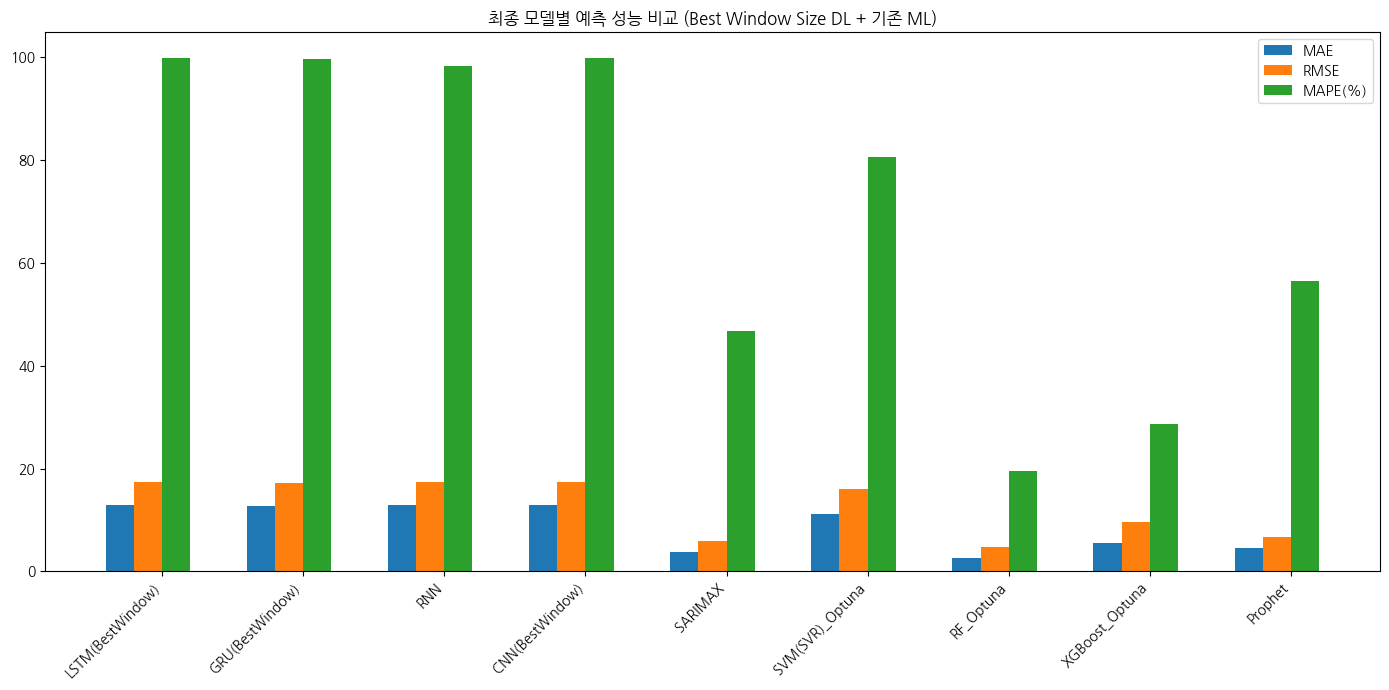


작업 완료! 각 모델의 성능 지표 및 튜닝 결과가 정리되었습니다.


In [33]:
########################################
# 12. 최종 결과 비교 및 시각화
########################################
# 모델 이름 수정 (Best Window Size DL 모델)
best_lstm_row['Model'] = 'LSTM(BestWindow)'
best_gru_row['Model'] = 'GRU(BestWindow)'
best_cnn_row['Model'] = 'CNN(BestWindow)'
sarimax_result['Model'] = 'SARIMAX'
svr_result_opt['Model'] = 'SVM(SVR)_Optuna'
rf_result_opt['Model'] = 'RF_Optuna'
xgb_result_opt['Model'] = 'XGBoost_Optuna'
prophet_result['Model'] = 'Prophet'

final_results_df_window = pd.DataFrame([
    best_lstm_row.to_dict(),
    best_gru_row.to_dict(),
    best_rnn_row.to_dict(),
    best_cnn_row.to_dict(),
    sarimax_result,
    svr_result_opt,
    rf_result_opt,
    xgb_result_opt,
    prophet_result,

])
final_results_df_window = final_results_df_window[['Model', 'Time Steps', 'Best Params', 'MAE', 'RMSE', 'MAPE']]
final_results_df_window.fillna('-', inplace=True)
print("\n=== 최종 모델별 성능 지표 비교 (Best Window Size DL + 기존 ML) ===")
display(final_results_df_window)

final_results_df_window.rename(columns={'MAPE': 'MAPE(%)'}, inplace=True)
final_results_df_window['MAPE(%)'] = final_results_df_window['MAPE(%)'] * 100

plt.figure(figsize=(14,7))
bar_x = np.arange(len(final_results_df_window))
plt.bar(bar_x - 0.3, final_results_df_window['MAE'], 0.2, label='MAE')
plt.bar(bar_x - 0.1, final_results_df_window['RMSE'], 0.2, label='RMSE')
plt.bar(bar_x + 0.1, final_results_df_window['MAPE(%)'], 0.2, label='MAPE(%)')
plt.xticks(bar_x, final_results_df_window['Model'], rotation=45, ha='right')
plt.title("최종 모델별 예측 성능 비교 (Best Window Size DL + 기존 ML)")
plt.legend()
plt.tight_layout()
plt.show()

gc.collect()
print("\n작업 완료! 각 모델의 성능 지표 및 튜닝 결과가 정리되었습니다.")

In [ ]:
# def evaluate_prophet_feature_importance(train_df, test_df, extra_regressors):
#     # 1. 모든 regressors를 사용한 모델(기준 모델) 성능 평가
#     baseline_model, baseline_forecast = train_prophet(train_df, test_df, extra_regressors)
#     baseline_pred = baseline_forecast['yhat'].values
#     baseline_perf = evaluate_performance(test_df['y'].values, baseline_pred, model_name="Prophet Baseline")

#     # baseline_perf가 {'MAE': value, 'RMSE': value, 'MAPE': value, ...} 형태라고 가정합니다.

#     importance_results = []
#     for reg in extra_regressors:
#         # 현재 Feature(reg)를 제외한 나머지 regressors를 사용
#         regressors_subset = [r for r in extra_regressors if r != reg]
#         model, forecast = train_prophet(train_df, test_df, extra_regressors=regressors_subset)
#         pred = forecast['yhat'].values
#         perf = evaluate_performance(test_df['y'].values, pred, model_name=f"Prophet without {reg}")

#         # 성능 지표 차이 계산 (예: 기준 모델과 비교하여 MAE, RMSE, MAPE가 얼마나 증가 또는 감소했는지)
#         # 값이 작아진다면 해당 변수의 제거가 성능 향상에 기여한 것으로 해석할 수 있습니다.
#         diff_mae = baseline_perf['MAE'] - perf['MAE']
#         diff_rmse = baseline_perf['RMSE'] - perf['RMSE']
#         diff_mape = baseline_perf['MAPE'] - perf['MAPE']
#         importance_results.append({
#             'Dropped Regressor': reg,
#             'MAE Diff': diff_mae,
#             'RMSE Diff': diff_rmse,
#             'MAPE Diff': diff_mape
#         })
#     return pd.DataFrame(importance_results)

# # extra_regressors (feature_cols)를 사용하여 Prophet 모델의 Feature 중요도 평가
# importance_df = evaluate_prophet_feature_importance(prophet_train, prophet_test, feature_cols)
# print("Extra Regressor 제거에 따른 성능 변화:")
# display(importance_df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/qyfy7dw2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/8_vk16vj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68459', 'data', 'file=/tmp/tmpsln3oz5z/qyfy7dw2.json', 'init=/tmp/tmpsln3oz5z/8_vk16vj.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_model9figsd8w/prophet_model-20250214021841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/6v3skmda.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/_i3bhzkc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

[Prophet Baseline] MAE=4.524, RMSE=6.630, MAPE=0.565


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/9_z0q9k4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/sz1prm0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34737', 'data', 'file=/tmp/tmpsln3oz5z/9_z0q9k4.json', 'init=/tmp/tmpsln3oz5z/sz1prm0k.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_modelae2w1dc6/prophet_model-20250214021842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without SO2] MAE=4.492, RMSE=6.580, MAPE=0.570


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/lni191lc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/2f0_6n6j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98163', 'data', 'file=/tmp/tmpsln3oz5z/lni191lc.json', 'init=/tmp/tmpsln3oz5z/2f0_6n6j.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_model48tjul71/prophet_model-20250214021842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without CO] MAE=4.551, RMSE=6.654, MAPE=0.572


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/srnhzcqo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/u_ix6os9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92740', 'data', 'file=/tmp/tmpsln3oz5z/srnhzcqo.json', 'init=/tmp/tmpsln3oz5z/u_ix6os9.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_model9q9h1p0m/prophet_model-20250214021842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without O3] MAE=4.330, RMSE=6.511, MAPE=0.536


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/2k6ldwim.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/_o3pmjaz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50290', 'data', 'file=/tmp/tmpsln3oz5z/2k6ldwim.json', 'init=/tmp/tmpsln3oz5z/_o3pmjaz.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_model9dadvnvi/prophet_model-20250214021843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without NO2] MAE=4.440, RMSE=6.528, MAPE=0.555


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/emwqphk6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/jyur73m7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6539', 'data', 'file=/tmp/tmpsln3oz5z/emwqphk6.json', 'init=/tmp/tmpsln3oz5z/jyur73m7.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_modelohxzeltr/prophet_model-20250214021843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without 평균최고기온(℃)] MAE=4.379, RMSE=6.428, MAPE=0.576


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/8atn6ree.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/lnl88scp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70945', 'data', 'file=/tmp/tmpsln3oz5z/8atn6ree.json', 'init=/tmp/tmpsln3oz5z/lnl88scp.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_modelmvrmi1mi/prophet_model-20250214021843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without 최대순간풍속(m/s)] MAE=4.528, RMSE=6.617, MAPE=0.586


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/oedrprd0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/dp1tb65n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90549', 'data', 'file=/tmp/tmpsln3oz5z/oedrprd0.json', 'init=/tmp/tmpsln3oz5z/dp1tb65n.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_model1xxigwmi/prophet_model-20250214021844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without PM10] MAE=4.502, RMSE=6.604, MAPE=0.569


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/24z7hmdf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/s27wfly9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15532', 'data', 'file=/tmp/tmpsln3oz5z/24z7hmdf.json', 'init=/tmp/tmpsln3oz5z/s27wfly9.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_modelpgie8sfn/prophet_model-20250214021844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without 일조합(hr)] MAE=4.385, RMSE=6.412, MAPE=0.597


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/6oeiedsr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/wo307xwt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91306', 'data', 'file=/tmp/tmpsln3oz5z/6oeiedsr.json', 'init=/tmp/tmpsln3oz5z/wo307xwt.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_model94o7jqtc/prophet_model-20250214021844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without PM25_lag5] MAE=4.519, RMSE=6.618, MAPE=0.569


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/d2d1qjz8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsln3oz5z/5b7x7pdt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28816', 'data', 'file=/tmp/tmpsln3oz5z/d2d1qjz8.json', 'init=/tmp/tmpsln3oz5z/5b7x7pdt.json', 'output', 'file=/tmp/tmpsln3oz5z/prophet_model3vtnf24h/prophet_model-20250214021845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without Traffic] MAE=3.907, RMSE=5.656, MAPE=0.571
[Prophet without Cases_lag1] MAE=8.848, RMSE=10.843, MAPE=1.561
Extra Regressor 제거에 따른 성능 변화:


,Dropped Regressor,MAE Diff,RMSE Diff,MAPE Diff
0,SO2,0.032685,0.050373,-0.005013
1,CO,-0.026904,-0.023445,-0.006793
2,O3,0.194476,0.119327,0.028891
3,NO2,0.084389,0.101924,0.010069
4,평균최고기온(℃),0.145100,0.202253,-0.011232
5,최대순간풍속(m/s),-0.003693,0.013376,-0.020900
6,PM10,0.022218,0.026409,-0.004172
7,일조합(hr),0.139779,0.218034,-0.031568
8,PM25_lag5,0.005770,0.012573,-0.004326
9,Traffic,0.617556,0.974236,-0.006076


In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_actual_vs_predicted(date_series, actual, predicted, model_name):
    # 예측 결과 길이에 맞춰 실제 데이터와 날짜 데이터 슬라이싱
    n = len(predicted)
    date_aligned = date_series.iloc[-n:] if hasattr(date_series, 'iloc') else date_series[-n:]
    actual_aligned = actual[-n:]

    plt.figure(figsize=(12,6))
    plt.plot(date_aligned, actual_aligned, label='실제값', marker='o', linestyle='-')
    plt.plot(date_aligned, predicted, label=f'{model_name} 예측값', marker='x', linestyle='--')
    plt.xlabel('날짜')
    plt.ylabel('확진자 수')
    plt.title(f'{model_name} 모델: 실제값 vs 예측값')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.tight_layout()
    plt.show()



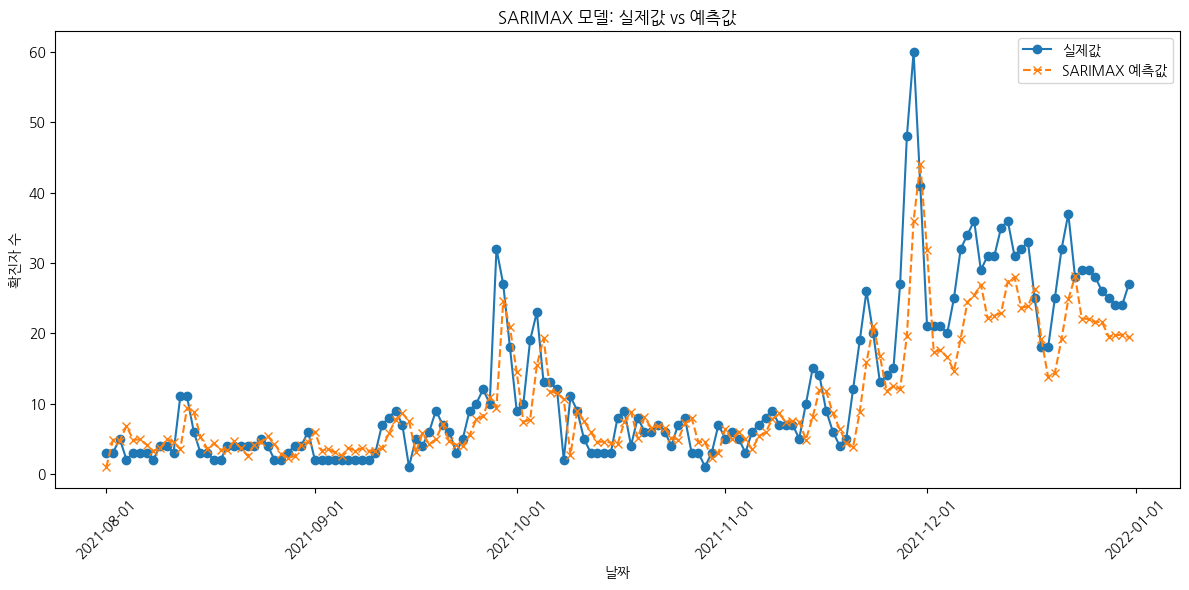

In [38]:
plot_actual_vs_predicted(test_df['Date'], y_test, sarimax_pred, "SARIMAX")


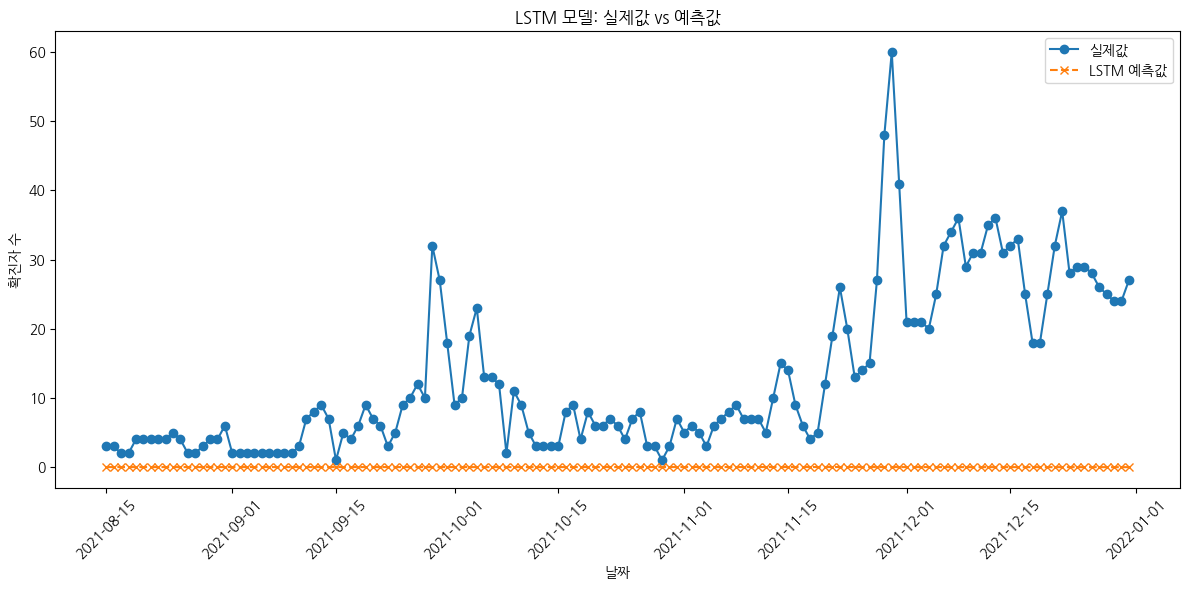

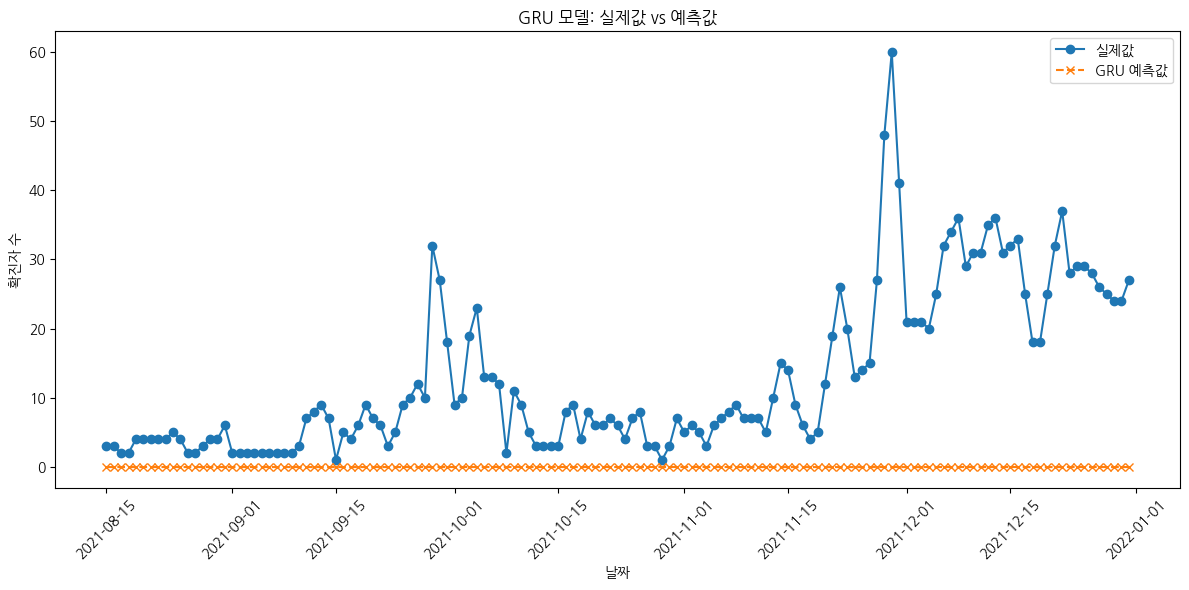

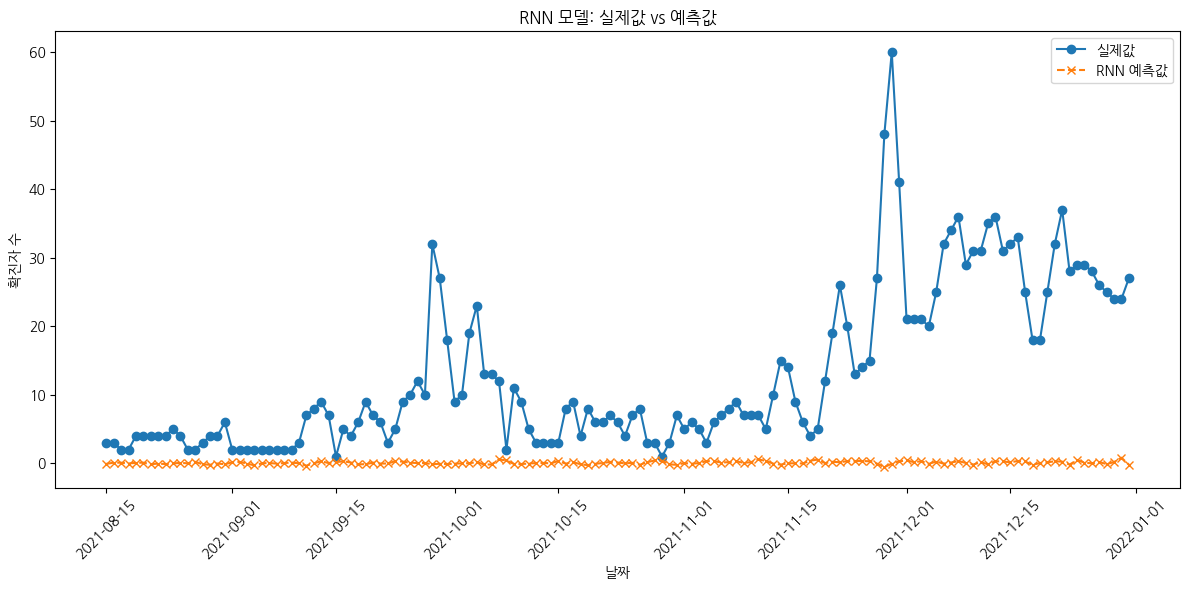

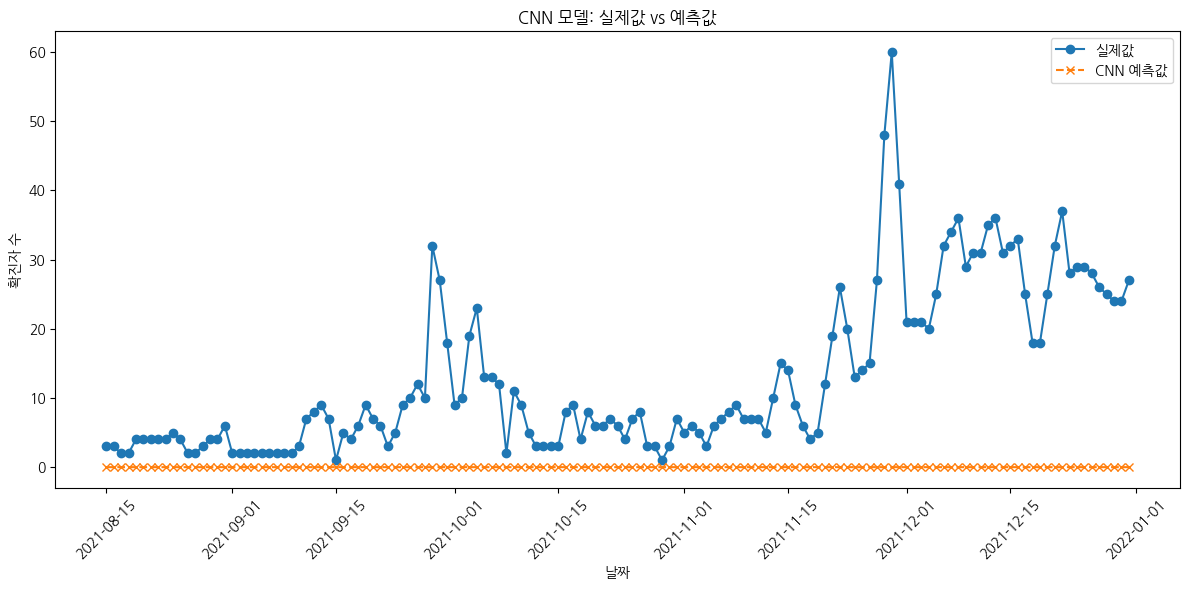

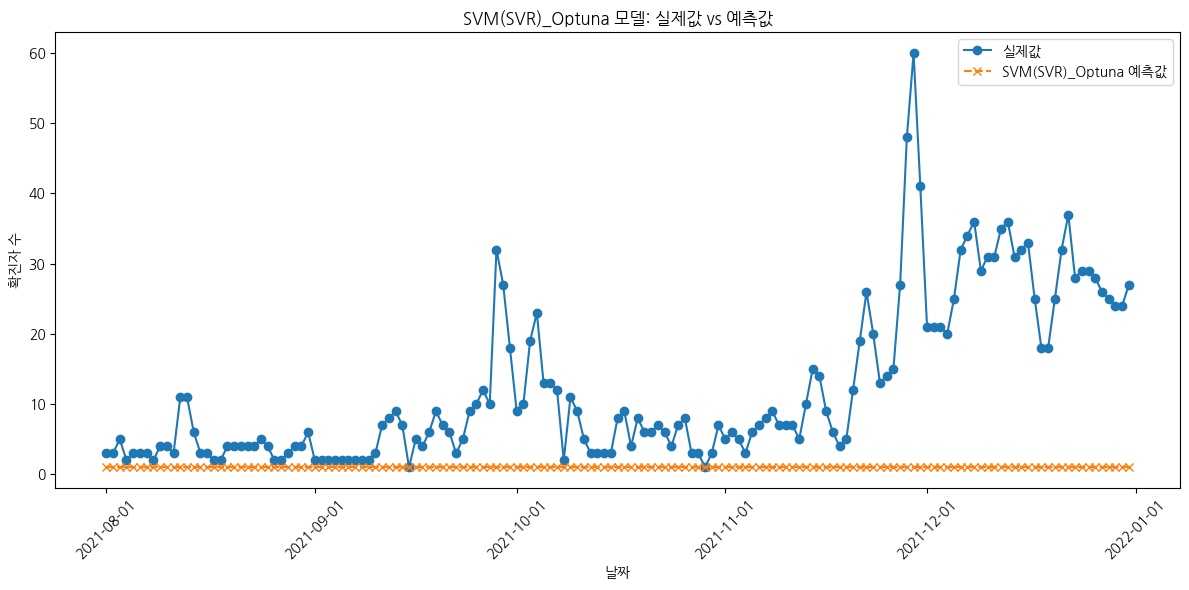

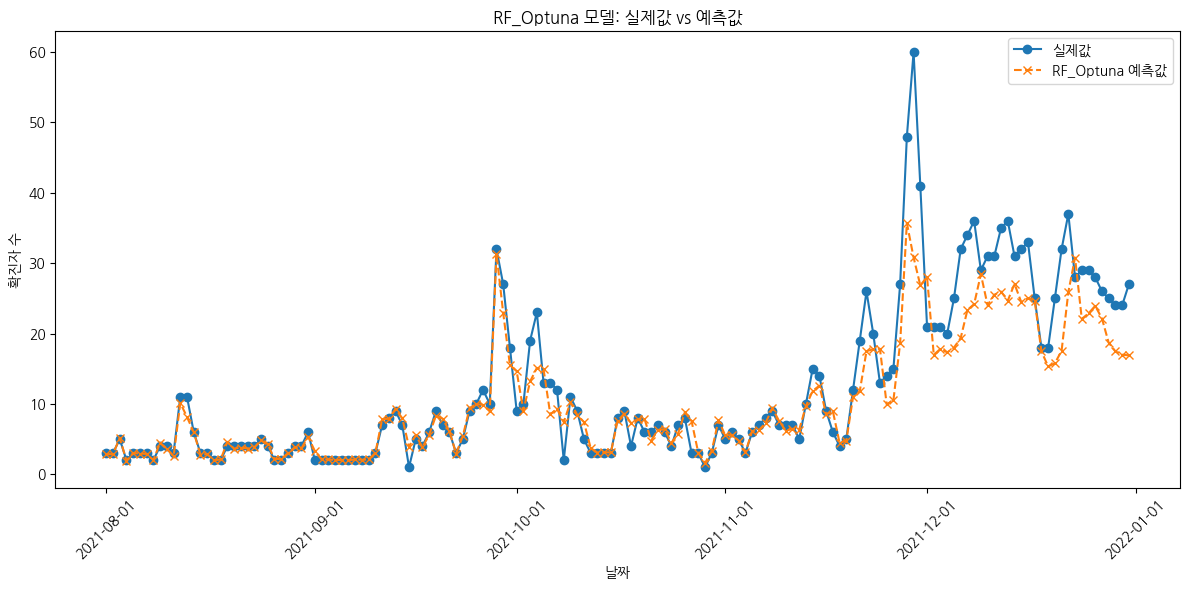

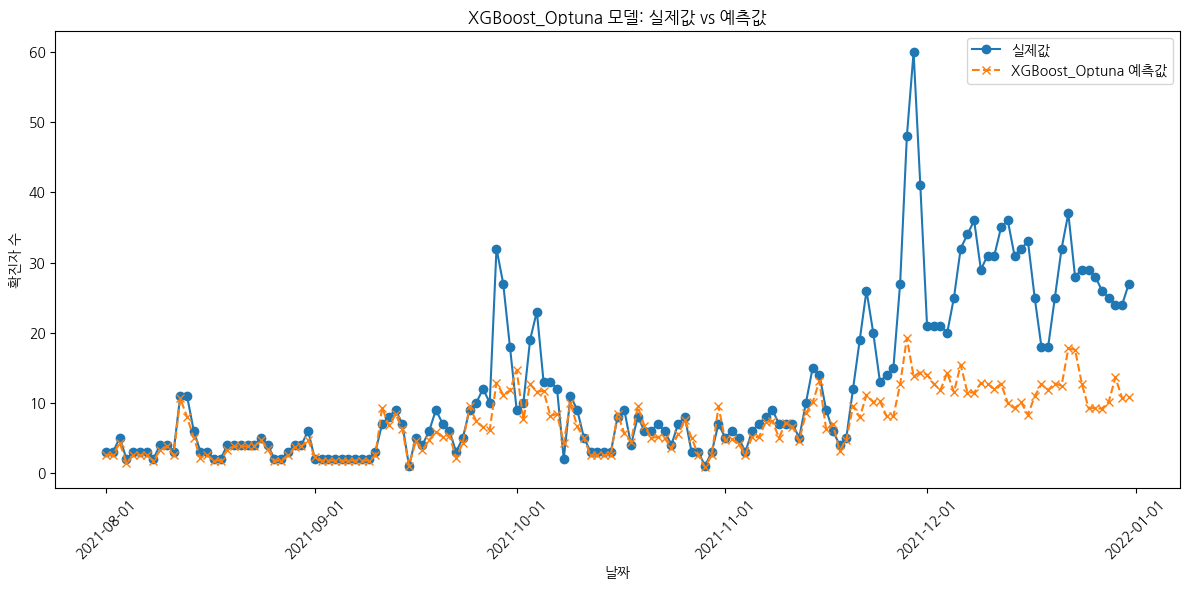

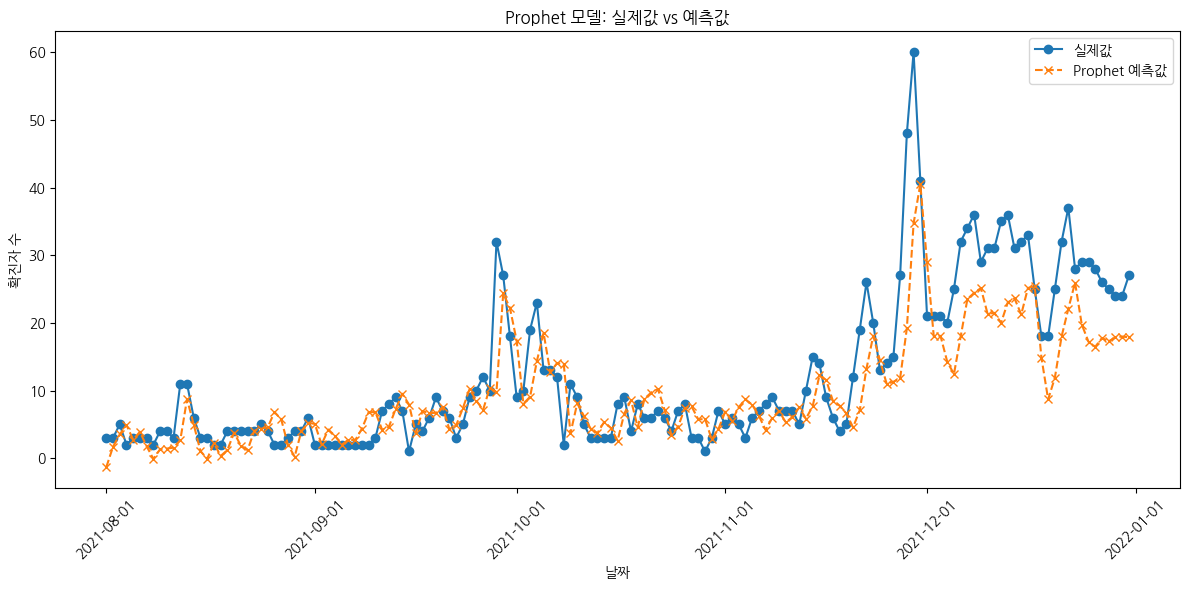

In [39]:
# LSTM 모델
plot_actual_vs_predicted(test_df['Date'], y_test, lstm_pred, "LSTM")

# GRU 모델
plot_actual_vs_predicted(test_df['Date'], y_test, gru_pred, "GRU")

# RNN 모델
plot_actual_vs_predicted(test_df['Date'], y_test, rnn_pred, "RNN")

# CNN 모델
plot_actual_vs_predicted(test_df['Date'], y_test, cnn_pred, "CNN")

# SVM (SVR) 최적화 모델
plot_actual_vs_predicted(test_df['Date'], y_test, svr_pred_opt, "SVM(SVR)_Optuna")

# Random Forest 최적화 모델
plot_actual_vs_predicted(test_df['Date'], y_test, rf_pred_opt, "RF_Optuna")

# XGBoost 최적화 모델
plot_actual_vs_predicted(test_df['Date'], y_test, xgb_pred_opt, "XGBoost_Optuna")

# Prophet 모델
plot_actual_vs_predicted(test_df['Date'], y_test, prophet_pred, "Prophet")
